# Result Visualization

Mirrors the structure of the result section.

In [1]:
import os
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import mean
from pandas.errors import SettingWithCopyWarning
from tqdm.auto import tqdm

import src.visualization.create_critical_difference_diagram as cdd
from src.visualization.visualization_utils import method_renaming, name_mapping
from src.visualization.visualization_utils import remove_cache_id

# result data paths:
ROOT_PATH = os.path.abspath("./../../results/")
BASELINES_PATH = os.path.join(ROOT_PATH, 'baselines')
LossVal_PATH = os.path.join(ROOT_PATH, 'lossval')
ACTIVE_DATA_ACQUISITION_PATH = os.path.join(ROOT_PATH, 'data_acquisition/experiment_results.csv')
ACTIVE_DATA_ACQUISITION_IMPORTANCE_SCORES_PATH = os.path.join(ROOT_PATH, 'data_acquisition/importance_scores.csv')
FIGURES_PATH = os.path.abspath("./../../figures/")

GENERAL_LR_CLASSIFICATION = 0.1
GENERAL_LR_REGRESSION = 0.01

MAIN_METHOD_NAME_REGR = "Weighted MSE loss with squared Sinkhorn"
MAIN_METHOD_NAME_CLASS = "Weighted CE loss with squared Sinkhorn"
BEST_LR_CLASSIFICATION = 0.01
BEST_LR_REGRESSION = 0.01

NOISE_TYPES = ["noisy_feature", "noisy_label", "mixed_noise"]
EPOCH_NRS_TO_CONSIDER = [5, 30]

LATEX_TEXTWIDTH_INCHES = 6.774 * 1.5    # Scale it by 1.5 because the font size is too large compared to our document
COLOR_PALETTE = "tab10"
ERRORBAR = "se"
ERR_STYLE = None #"band" #"bars"

In [2]:
sns.set_style("white")
sns.set_context('paper')
sns.set_palette(COLOR_PALETTE)
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
# Load data (LossVal)
LossVal_classification_results_with_ablation = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}
LossVal_classification_results = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}

for root, dirs, files in tqdm(list(os.walk(os.path.join(LossVal_PATH, "classification"))), desc="Loading LossVal classification results"):
    for file in files:
        if file.endswith(".csv"):
            # Load the file
            noise_type = "_".join(file.split("_")[0:2])
            task_type = "_".join(file.split("_")[3:-1])
            df = pd.read_csv(os.path.join(root, file))

            # Add "[ABLATION] " after "LossValEvaluator(loss=" if its not already there:
            df["method"] = df["method"].apply(lambda x: x if "[ABLATION]" in x else x.replace("LossValEvaluator(loss=", "LossValEvaluator(loss=[ABLATION] "))
            df["method"] = df["method"].apply(lambda x: x if MAIN_METHOD_NAME_CLASS+"," not in x else x.replace("[ABLATION] ", ""))
            df.to_csv(os.path.join(root, file), index=False)

            # Rename the methods names
            df["method"] = df["method"].apply(method_renaming)

            # Add the new data to the corresponding dataframe in the dict:
            LossVal_classification_results_with_ablation[noise_type][task_type] = pd.concat([LossVal_classification_results_with_ablation[noise_type][task_type], df], ignore_index=True)

            df_without_ablation = df[~df["method"].str.contains("ABLATION")]
            LossVal_classification_results[noise_type][task_type] = pd.concat([LossVal_classification_results[noise_type][task_type], df_without_ablation], ignore_index=True)

LossVal_regression_results_with_ablation = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}
LossVal_regression_results = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}

for root, dirs, files in tqdm(list(os.walk(os.path.join(LossVal_PATH, "regression"))), desc="Load LossVal regression results"):
    for file in files:
        if file.endswith(".csv"):
            # Load the file
            noise_type = "_".join(file.split("_")[0:2])
            task_type = "_".join(file.split("_")[3:-1])
            df = pd.read_csv(os.path.join(root, file))

            df = df[~df["method"].str.contains("correction")]
            # Add "[ABLATION] " after "LossValEvaluator(loss=" if its not already there:
            df["method"] = df["method"].apply(lambda x: x if "[ABLATION]" in x else x.replace("LossValEvaluator(loss=", "LossValEvaluator(loss=[ABLATION] "))
            df["method"] = df["method"].apply(lambda x: x if MAIN_METHOD_NAME_REGR+"," not in x else x.replace("[ABLATION] ", ""))
            df.to_csv(os.path.join(root, file), index=False)

            # Rename the methods names
            df["method"] = df["method"].apply(method_renaming)

            # Add the new data to the corresponding dataframe in the dict:
            LossVal_regression_results_with_ablation[noise_type][task_type] = pd.concat([LossVal_regression_results_with_ablation[noise_type][task_type], df], ignore_index=True)

            df_without_ablation = df[~df["method"].str.contains("ABLATION")]
            LossVal_regression_results[noise_type][task_type] = pd.concat([LossVal_regression_results[noise_type][task_type], df_without_ablation], ignore_index=True)

Loading LossVal classification results:   0%|          | 0/7 [00:00<?, ?it/s]

Load LossVal regression results:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# Load data (baselines)
baseline_results_classification = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}

for root, dirs, files in os.walk(os.path.join(BASELINES_PATH, "classification")):
    for file in files:
        if file.endswith(".csv"):
            # Load the file
            noise_type = "_".join(file.split("_")[0:2])
            task_type = "_".join(file.split("_")[3:-1])
            df = remove_cache_id(pd.read_csv(os.path.join(root, file)))
            df = df[~df["method"].str.contains("Random")]
            
            # df["method"] = df["method"].apply(lambda x: x.replace("(simple)", "with logistic/linear regression"))
            df = df[~df["method"].str.contains("(simple)")]

            # Remove everything in brackets from the method name:
            df["method"] = df["method"].apply(lambda x: x.split("(")[0])
            df = name_mapping(df)
            df["method"] = df["method"].apply(lambda x: x.replace("DataOOB", "Data-OOB"))

            
            # Add the new data to the corresponding dataframe in the dict:
            baseline_results_classification[noise_type][task_type] = pd.concat([baseline_results_classification[noise_type][task_type], df], ignore_index=True)
            
baseline_results_regression = {
    "noisy_feature": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "noisy_label": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    },
    "mixed_noise": {
        "corruption_discovery": pd.DataFrame(),
        "f1": pd.DataFrame(),
        "remove_high_low": pd.DataFrame()
    }
}

for root, dirs, files in os.walk(os.path.join(BASELINES_PATH, "regression")):
    for file in files:
        if file.endswith(".csv"):
            # Load the file
            noise_type = "_".join(file.split("_")[0:2])
            task_type = "_".join(file.split("_")[3:-1])
            df = remove_cache_id(pd.read_csv(os.path.join(root, file)))
            df = df[~df["method"].str.contains("Random")]
            
            # df["method"] = df["method"].apply(lambda x: x.replace("(simple)", "with logistic/linear regression"))
            df = df[~df["method"].str.contains("simple")]

            # Remove everything in brackets from the method name:
            df["method"] = df["method"].apply(lambda x: x.split("(")[0])
            df = name_mapping(df)

            df["method"] = df["method"].apply(lambda x: x.replace("DataOOB", "Data-OOB"))

            # Add the new data to the corresponding dataframe in the dict:
            baseline_results_regression[noise_type][task_type] = pd.concat([baseline_results_regression[noise_type][task_type], df], ignore_index=True)

C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\1681730721.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["method"].str.contains("(simple)")]
C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\1681730721.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["method"].str.contains("(simple)")]
C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\1681730721.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["method"].str.contains("(simple)")]
C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\1681730721.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["method"].str.contains("(simple)

In [5]:
baseline_results_regression["noisy_feature"]["f1"]["method"].unique()

array(['KNN-Shapley', 'DVRL', 'AME', 'Data Banzhaf',
       'Influence Subsample', 'Data-OOB', 'Leave-One-Out', 'LAVA',
       'Beta Shapley', 'Data Shapley'], dtype=object)

In [6]:
baseline_methods_to_use = set(baseline_results_regression["noisy_feature"]["f1"]["method"].unique()) & set(baseline_results_classification["noisy_feature"]["f1"]["method"].unique())

print("Methods to use for the baselines:", baseline_methods_to_use)

Methods to use for the baselines: {'LAVA', 'AME', 'Data-OOB', 'Influence Subsample', 'DVRL', 'Data Shapley', 'Leave-One-Out', 'Beta Shapley', 'Data Banzhaf', 'KNN-Shapley'}


In [7]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [8]:
# Get default color palette (COLOR_PALETTE; map method names to colors)
color_palette = sns.color_palette(COLOR_PALETTE)

# selected_colors = [1, 2, 4, 5, 6, 7, 8, 9]
# modified_palette = [sns.color_palette("tab10")[i] for i in selected_colors]
modified_palette = sns.color_palette("tab10")

baselines_sorted = sorted(baseline_methods_to_use)

color_dict = {baselines_sorted[i]: color for i, color in enumerate(modified_palette[:len(baselines_sorted)])}

color_dict["LossVal (epochs=5)"] = tuple(c / 256 for c in (20, 12, 105))
color_dict["LossVal (epochs=30)"] = tuple(c / 256 for c in (11, 108, 153))

# Add alpha to all that are not LossVal:
for method in color_dict.keys():
    if "LossVal" not in method:
        color_dict[method] += (0.8,)
        
color_dict

{'AME': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.8),
 'Beta Shapley': (1.0, 0.4980392156862745, 0.054901960784313725, 0.8),
 'DVRL': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.8),
 'Data Banzhaf': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  0.8),
 'Data Shapley': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  0.8),
 'Data-OOB': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  0.8),
 'Influence Subsample': (0.8901960784313725,
  0.4666666666666667,
  0.7607843137254902,
  0.8),
 'KNN-Shapley': (0.4980392156862745,
  0.4980392156862745,
  0.4980392156862745,
  0.8),
 'LAVA': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.8),
 'Leave-One-Out': (0.09019607843137255,
  0.7450980392156863,
  0.8117647058823529,
  0.8),
 'LossVal (epochs=5)': (0.078125, 0.046875, 0.41015625),
 'LossVal (epochs=30)': (0.04296875, 0.421875, 0.59765625)}

## Noisy Sample Detection

In [9]:
# Average over all datasets
# Classification
temp_nl = pd.concat([baseline_results_classification["noisy_feature"]["corruption_discovery"], LossVal_classification_results["noisy_feature"]["corruption_discovery"]])
temp_nl["plot_axis"] = "Noisy Features"

temp_nf = pd.concat([baseline_results_classification["noisy_label"]["corruption_discovery"], LossVal_classification_results["noisy_label"]["corruption_discovery"]])
temp_nf["plot_axis"] = "Noisy Labels"

temp_mn = pd.concat([baseline_results_classification["mixed_noise"]["corruption_discovery"], LossVal_classification_results["mixed_noise"]["corruption_discovery"]])
temp_mn["plot_axis"] = "Mixed Noise"

plotting_df_class = pd.concat([temp_nl, temp_nf, temp_mn])
plotting_df_class = plotting_df_class[
        ~plotting_df_class["method"].str.contains("ABLATION") &
        (~plotting_df_class["method"].str.contains("LossVal") |
         plotting_df_class["method"].str.contains(f"lr={BEST_LR_CLASSIFICATION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_class = plotting_df_class[
    (~plotting_df_class["method"].str.contains("LossVal") |
     plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
     plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]

# Drop all that are neither LossVal nor OOB
# plotting_df_class = plotting_df_class[
#      plotting_df_class["method"].str.contains("LossVal") |
#      plotting_df_class["method"].str.contains("OOB")
# ]

# Average over all datasets
# Regression
temp_nl = pd.concat([baseline_results_regression["noisy_feature"]["corruption_discovery"], LossVal_regression_results["noisy_feature"]["corruption_discovery"]])
temp_nl["plot_axis"] = "Noisy Features"

temp_nf = pd.concat([baseline_results_regression["noisy_label"]["corruption_discovery"], LossVal_regression_results["noisy_label"]["corruption_discovery"]])
temp_nf["plot_axis"] = "Noisy Labels"

temp_mn = pd.concat([baseline_results_regression["mixed_noise"]["corruption_discovery"], LossVal_regression_results["mixed_noise"]["corruption_discovery"]])
temp_mn["plot_axis"] = "Mixed Noise"

plotting_df_regr = pd.concat([temp_nl, temp_nf, temp_mn])
plotting_df_regr = plotting_df_regr[
        ~plotting_df_regr["method"].str.contains("ABLATION") &
        (~plotting_df_regr["method"].str.contains("LossVal") |
          plotting_df_regr["method"].str.contains(f"lr={BEST_LR_REGRESSION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_regr = plotting_df_regr[
    (~plotting_df_regr["method"].str.contains("LossVal") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]

# Drop all that are neither LossVal nor OOB
# plotting_df_regr = plotting_df_regr[
#      plotting_df_regr["method"].str.contains("LossVal") |
#      plotting_df_regr["method"].str.contains("OOB")
# ]

# Remove learning rate ("lr=n") from the LossVal method names:
plotting_df_class["method"] = plotting_df_class["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))
plotting_df_regr["method"] = plotting_df_regr["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))

In [10]:
plotting_df_regr["method"].unique()

array(['Influence Subsample', 'Leave-One-Out', 'Data Banzhaf', 'Data-OOB',
       'AME', 'DVRL', 'KNN-Shapley', 'LAVA', 'Data Shapley',
       'Beta Shapley', 'LossVal (epochs=5)', 'LossVal (epochs=30)'],
      dtype=object)

Subplots to create: ['Noisy Labels', 'Noisy Features', 'Mixed Noise']


C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\532966819.py:90: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saving figure to C:\Users\timwi\Documents\Uni\LossVal\figures\exp_1/noisy_sample_detection.pdf


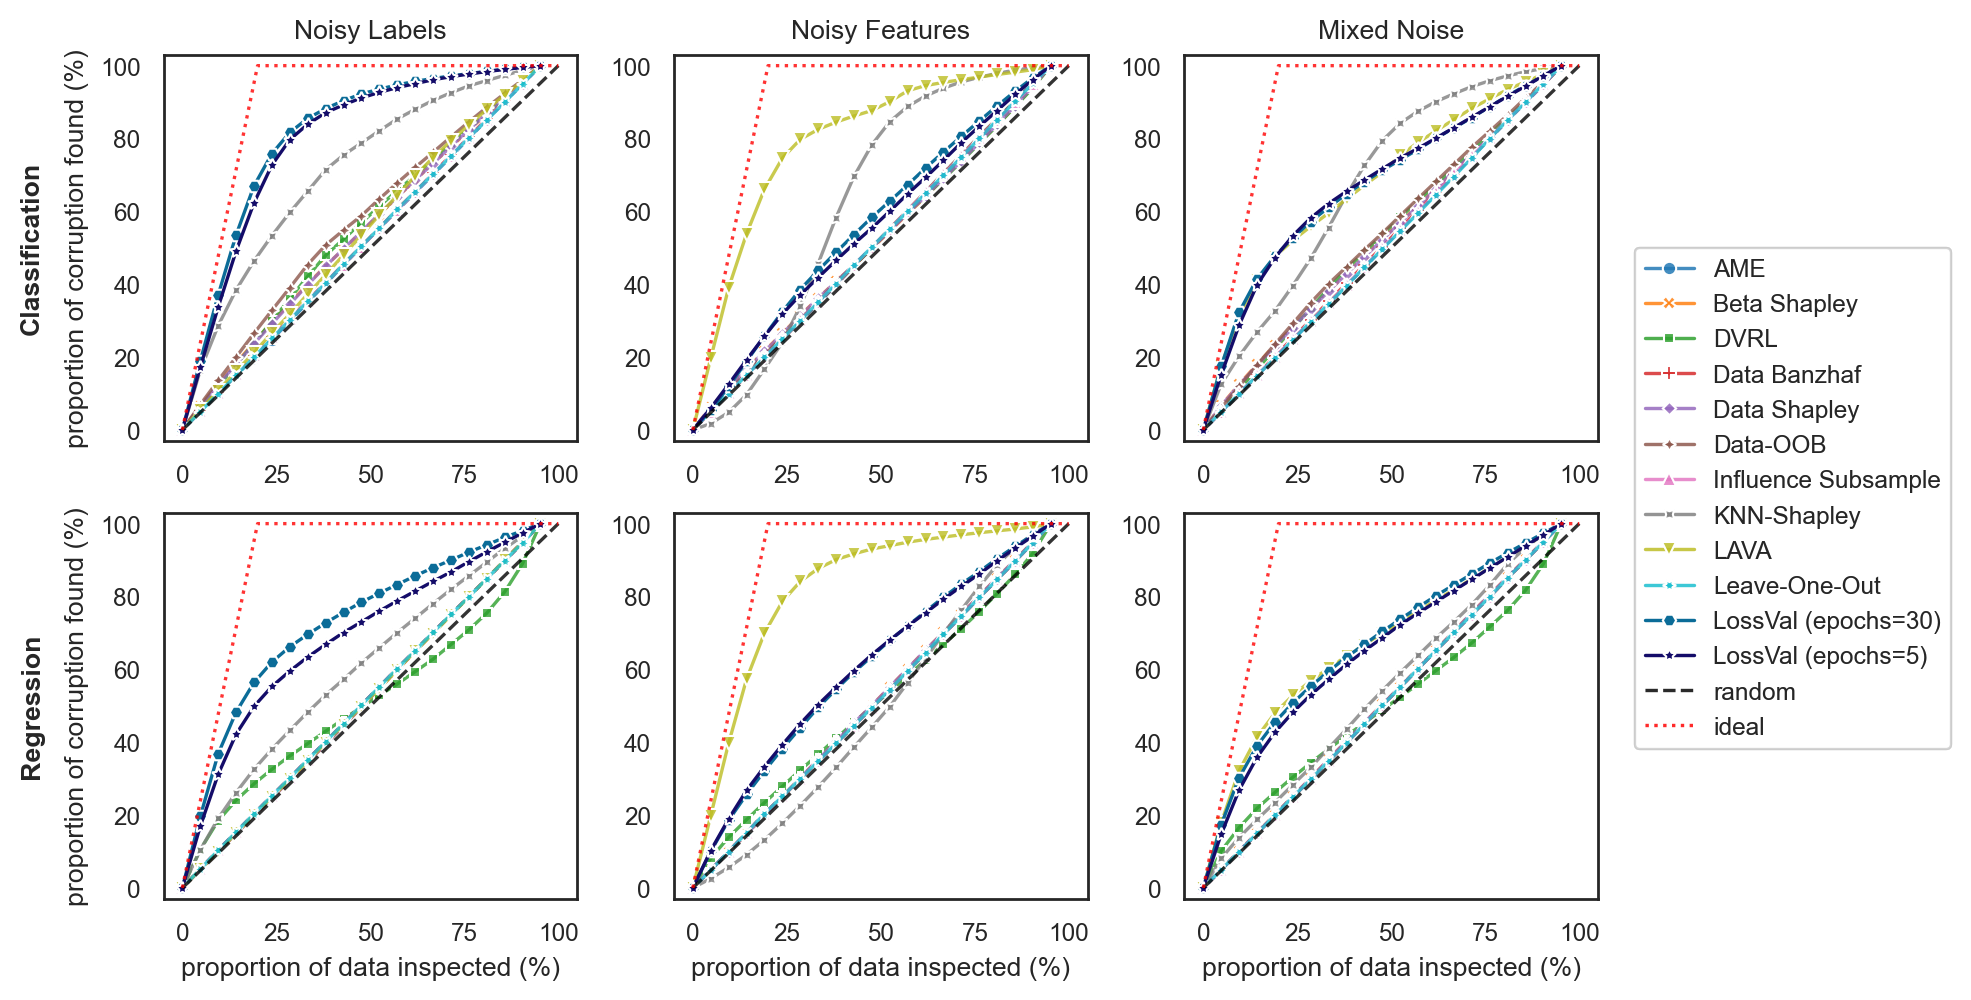

In [11]:
def plot_noisy_sample_detection_both(df_class, df_regr, noise_rate=0.2, save_path=None, alpha=0.8):
    warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
    list_of_plots = ['Noisy Labels', 'Noisy Features', 'Mixed Noise']
    print("Subplots to create:", list_of_plots)

    n_cols = len(list_of_plots)
    fig, axs = plt.subplots(2, n_cols, figsize=(LATEX_TEXTWIDTH_INCHES*0.8, LATEX_TEXTWIDTH_INCHES/2), layout='constrained',)
    
    end_points = [{'corrupt_found': 1., 'axis': 1., 'method': meth, 'noise_rate': noise_rate} for
                    meth in df_class['method'].unique()]
    end_points_df = pd.DataFrame(end_points)
    df_class = pd.concat([df_class, end_points_df], ignore_index=True)
    df_regr = pd.concat([df_regr, end_points_df], ignore_index=True)
    
    df_class = df_class.sort_values(by='method')
    df_regr = df_regr.sort_values(by='method')
    
    # Group by method, dataset, noise_rate, model and take the mean
    df_scaled_class = df_class[df_class["noise_rate"] == noise_rate].copy()
    df_scaled_class['corrupt_found'] = df_scaled_class['corrupt_found'] * 100
    df_scaled_class['axis'] = df_scaled_class['axis'] * 100

    df_regr_scaled = df_regr[df_regr["noise_rate"] == noise_rate].copy()
    df_regr_scaled['corrupt_found'] = df_regr_scaled['corrupt_found'] * 100
    df_regr_scaled['axis'] = df_regr_scaled['axis'] * 100
    
    # If either classification or regression is missing a method, remove it from both and print a warning:
    methods_used = set(df_scaled_class["method"].unique()) & set(df_regr_scaled["method"].unique())
    removed_methods = set(df_class["method"].unique()) ^ set(df_regr["method"].unique())
    if len(removed_methods) > 0:
        print("Warning: Some methods are missing from either classification or regression. Removed:", removed_methods)
        df_scaled_class = df_scaled_class[df_scaled_class["method"].isin(methods_used)]
        df_regr_scaled = df_regr_scaled[df_regr_scaled["method"].isin(methods_used)]   
            
    # Classification (top row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[0, i]
        
        df_plot = df_scaled_class[df_scaled_class['plot_axis'] == plot_axis]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='corrupt_found', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        
        ax.set_title(plot_axis)
        ax.set_ylim(-3, 103)
        
        # Add "random" line and "ideal" line:
        ax.plot([0, 100], [0, 100], linestyle='--', color='black', label="random", alpha=alpha)
        ax.plot([0, noise_rate * 100, 100], [0, 100, 100], linestyle=':', color='red', label="ideal", alpha=alpha)
        
        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("proportion of corruption found (%)")
            ax.text(-40, 50, "Classification", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)
            
        ax.set_xlabel(None)
        ax.legend()

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1, 0.5))
        ax.get_legend().remove()  # Remove the legend from the subplot
    
    # Regression (second row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[1, i]
        
        df_plot = df_regr_scaled[df_regr_scaled['plot_axis'] == plot_axis]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='corrupt_found', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        
        ax.set_ylim(-3, 103)
        
        # Add "random" line and "ideal" line:
        ax.plot([0, 100], [0, 100], linestyle='--', color='black', label="random", alpha=alpha)
        ax.plot([0, noise_rate * 100, 100], [0, 100, 100], linestyle=':', color='red', label="ideal", alpha=alpha)
        
        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("proportion of corruption found (%)")
            ax.text(-40, 50, "Regression", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)

        ax.set_xlabel("proportion of data inspected (%)")
        ax.get_legend().remove()  # Remove the legend from the subplot

    plt.tight_layout()
    
    if save_path is not None:
        print(f"Saving figure to {save_path}")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    

plot_noisy_sample_detection_both(plotting_df_class, plotting_df_regr, save_path=os.path.join(FIGURES_PATH, "exp_1/noisy_sample_detection.pdf"), alpha=0.8)

In [12]:
def calculate_avg_for_corruption_detection(df):
    # Calculate area under the curve for each method and each noise level and task. Also calculate overall AUC per method.
    df = df.copy()
    df["corrupt_found"] = df["corrupt_found"] * 100
    df["optimal"] = df["optimal"] * 100
    
    df_temp = df.copy()
    df_temp["plot_axis"] = "avg."
    
    df = pd.concat([df, df_temp])
    
    df_agg = df[["method", "plot_axis", "corrupt_found", "optimal"]].groupby(
        ["method", "plot_axis"], as_index=True).agg(['mean','sem'])
    
    df_agg = df_agg["corrupt_found"][["mean", "sem"]].reset_index()
    
    return df_agg

calculate_avg_for_corruption_detection(plotting_df_class)

,method,plot_axis,mean,sem
0,AME,Mixed Noise,50.004431,0.272407
1,AME,Noisy Features,49.814696,0.271282
2,AME,Noisy Labels,49.980794,0.271212
3,AME,avg.,49.933307,0.156824
4,Beta Shapley,Mixed Noise,51.756504,0.271200
5,Beta Shapley,Noisy Features,50.126812,0.263698
6,Beta Shapley,Noisy Labels,53.323849,0.269914
7,Beta Shapley,avg.,51.735441,0.155026
8,DVRL,Mixed Noise,52.068995,0.272294
9,DVRL,Noisy Features,49.966931,0.272269


In [13]:
def create_latex_table_for_corruption_detection(df):
    optimal = mean([(100*100-i*100/2)/100 for i in [5, 10, 15, 20]])
    random = (100*100/2)/100
    print("Optimal avg:", optimal, "\nRandom avg:", random)
    
    latex_cols = ["Noisy Labels", "Noisy Features", "Mixed Noise", "avg."]

    # Create a latex table for the AUC values
    df = df.pivot(index="method", columns="plot_axis", values=["mean", "sem"])

    # Highlight the best 3 results (higher is better) in each column (1st -> bold, 2nd -> underlined, 3rd -> italic)
    for col in latex_cols:
        df[f"{col}_rank"] = df["mean"][col].rank(ascending=False)
        df[f"{col}_rank"] = df[f"{col}_rank"].apply(lambda x: "\\textbf{" if x == 1 else "\\underline{" if x == 2 else "\\textit{" if x == 3 else "" )
        df[col] = df["mean"][col].apply(lambda x: f"{x:.2f}")
        df[col] = df[f"{col}_rank"] + df[col].astype(str) + df[f"{col}_rank"].apply(lambda x: "}" if x != "" else "")
        
        df[f"{col}_sem"] = df["sem"][col].apply(lambda x: f"{x:.2f}")
        df[col] = df[col] + "$\\pm$" + df[f"{col}_sem"]
    
    # # Drop the rank columns
    df = df[latex_cols]
 
    # return df       
    # Convert to latex table, where the best 3 results are highlighted
    latex_table = df.to_latex()
    latex_table = latex_table.replace("\\toprule", "\\toprule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\midrule", "\\midrule\n\\rowcolor{gray!3}")
    latex_table = latex_table.replace("\\bottomrule", "\\bottomrule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\textbackslash ", "\\")
    latex_table = latex_table.replace("\\{", "{")
    latex_table = latex_table.replace("\\}", "}")
    latex_table = latex_table.replace("\\$", "$")
    
    return latex_table

In [14]:
res_df_class = calculate_avg_for_corruption_detection(plotting_df_class)
res_df_regr = calculate_avg_for_corruption_detection(plotting_df_regr)
res_df_overall = calculate_avg_for_corruption_detection(pd.concat([plotting_df_class, plotting_df_regr]))

In [15]:
print(create_latex_table_for_corruption_detection(res_df_class))

Optimal avg: 93.75 
Random avg: 50.0
\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              49.98$\pm$0.27 &              49.81$\pm$0.27 &              50.00$\pm$0.27 &              49.93$\pm$0.16 \\
Beta Shapley        &              53.32$\pm$0.27 &              50.13$\pm$0.26 &              51.76$\pm$0.27 &              51.74$\pm$0.16 \\
DVRL                &              53.87$\pm$0.28 &              49.97$\pm$0.27 &              52.07$\pm$0.27 &              51.97$\pm$0.16 \\
Data Banzhaf        &              50.35$\pm$0.27 &              49.97$\pm$0.27 &              50.04$\pm$0.27 &              50.12$\pm$0.16 \\
Data Shapley        &          

In [16]:
print(create_latex_table_for_corruption_detection(res_df_regr))

Optimal avg: 93.75 
Random avg: 50.0
\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              49.85$\pm$0.27 &              50.04$\pm$0.27 &              49.87$\pm$0.27 &              49.92$\pm$0.16 \\
Beta Shapley        &              50.14$\pm$0.27 &              50.10$\pm$0.27 &              50.15$\pm$0.27 &              50.13$\pm$0.16 \\
DVRL                &              49.66$\pm$0.29 &              50.00$\pm$0.27 &              49.25$\pm$0.27 &              49.63$\pm$0.16 \\
Data Banzhaf        &              49.85$\pm$0.27 &              50.04$\pm$0.27 &              49.87$\pm$0.27 &              49.92$\pm$0.16 \\
Data Shapley        &          

In [17]:
print(create_latex_table_for_corruption_detection(res_df_overall))

Optimal avg: 93.75 
Random avg: 50.0
\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              49.91$\pm$0.19 &              49.93$\pm$0.19 &              49.94$\pm$0.19 &              49.93$\pm$0.11 \\
Beta Shapley        &              51.73$\pm$0.19 &              50.11$\pm$0.19 &              50.94$\pm$0.19 &              50.93$\pm$0.11 \\
DVRL                &              51.77$\pm$0.20 &              49.98$\pm$0.19 &              50.66$\pm$0.19 &              50.80$\pm$0.11 \\
Data Banzhaf        &              50.10$\pm$0.19 &              50.01$\pm$0.19 &              49.95$\pm$0.19 &              50.02$\pm$0.11 \\
Data Shapley        &          

### F1 Scores

In [18]:
temp_nl_class = pd.concat([baseline_results_classification["noisy_feature"]["f1"], LossVal_classification_results_with_ablation["noisy_feature"]["f1"]])
temp_nl_class["plot_axis"] = "Noisy Features"

temp_nf_class = pd.concat([baseline_results_classification["noisy_label"]["f1"], LossVal_classification_results_with_ablation["noisy_label"]["f1"]])
temp_nf_class["plot_axis"] = "Noisy Labels"

temp_mn_class = pd.concat([baseline_results_classification["mixed_noise"]["f1"], LossVal_classification_results_with_ablation["mixed_noise"]["f1"]])
temp_mn_class["plot_axis"] = "Mixed Noise"

temp_nl_regr = pd.concat([baseline_results_regression["noisy_feature"]["f1"], LossVal_regression_results_with_ablation["noisy_feature"]["f1"]])
temp_nl_regr["plot_axis"] = "Noisy Features"

temp_nf_regr = pd.concat([baseline_results_regression["noisy_label"]["f1"], LossVal_regression_results_with_ablation["noisy_label"]["f1"]])
temp_nf_regr["plot_axis"] = "Noisy Labels"

temp_mn_regr = pd.concat([baseline_results_regression["mixed_noise"]["f1"], LossVal_regression_results_with_ablation["mixed_noise"]["f1"]])
temp_mn_regr["plot_axis"] = "Mixed Noise"

plotting_df_class = pd.concat([temp_nl_class, temp_nf_class, temp_mn_class])
plotting_df_class = plotting_df_class[
        ~plotting_df_class["method"].str.contains("ABLATION") &
        (~plotting_df_class["method"].str.contains("LossVal") |
         plotting_df_class["method"].str.contains(f"lr={BEST_LR_CLASSIFICATION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_class = plotting_df_class[
    (~plotting_df_class["method"].str.contains("LossVal") |
     plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
     plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]
    
    
    
plotting_df_regr = pd.concat([temp_nl_regr, temp_nf_regr, temp_mn_regr])
plotting_df_regr = plotting_df_regr[
        ~plotting_df_regr["method"].str.contains("ABLATION") &
        (~plotting_df_regr["method"].str.contains("LossVal") |
          plotting_df_regr["method"].str.contains(f"lr={BEST_LR_REGRESSION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_regr = plotting_df_regr[
    (~plotting_df_regr["method"].str.contains("LossVal") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]

# Remove learning rate ("lr=n") from the LossVal method names:
plotting_df_class["method"] = plotting_df_class["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))
plotting_df_regr["method"] = plotting_df_regr["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))

# Drop all that are neither LossVal nor OOB
# plotting_df_class = plotting_df_class[
#      plotting_df_class["method"].str.contains("LossVal") |
#      plotting_df_class["method"].str.contains("OOB")
# ]
# 
# # Drop all that are neither LossVal nor OOB
# plotting_df_regr = plotting_df_regr[
#      plotting_df_regr["method"].str.contains("LossVal") |
#      plotting_df_regr["method"].str.contains("OOB")
# ]

# Select shared subset for both classification and regression:
methods_used = set(plotting_df_class["method"].unique()) & set(plotting_df_regr["method"].unique())
plotting_df_class = plotting_df_class[plotting_df_class["method"].isin(methods_used)]
plotting_df_regr = plotting_df_regr[plotting_df_regr["method"].isin(methods_used)]

Subplots to create: ['Noisy Labels', 'Noisy Features', 'Mixed Noise']


C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\4219333396.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


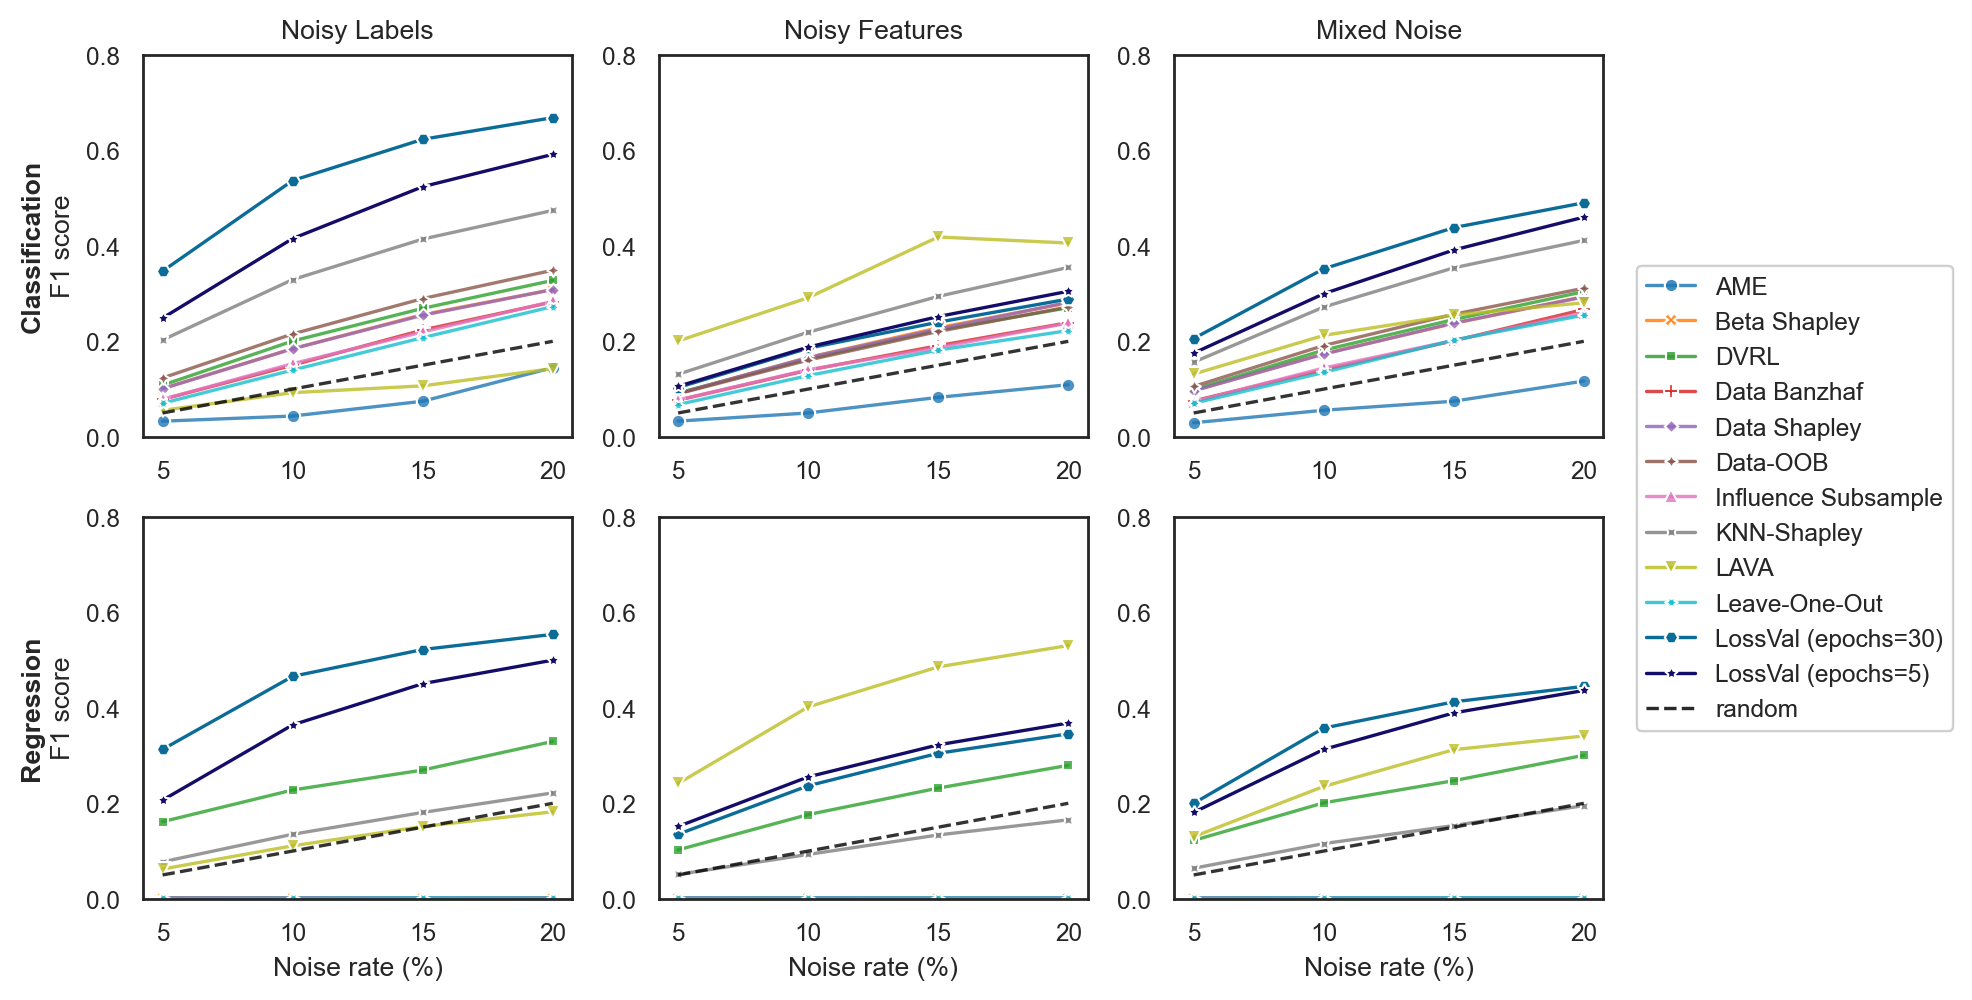

In [19]:
random_line_y = [0.05, 0.1, 0.15, 0.2]
random_line_x = [5, 10, 15, 20]

def plot_f1_scores_for_both(df_class, df_regr, save_path=None, alpha=0.8):
    """ Plot regression and classification F1 scores in the same plot. Top row is classification, bottom row is regression. """
    warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

    list_of_plots = ['Noisy Labels', 'Noisy Features', 'Mixed Noise']
    print("Subplots to create:", list_of_plots)

    n_subplots = len(list_of_plots)
    n_cols = n_subplots
    fig, axs = plt.subplots(2, n_cols, figsize=(LATEX_TEXTWIDTH_INCHES*0.8, LATEX_TEXTWIDTH_INCHES/2), layout='constrained',)

    df_class = df_class.sort_values(by='method')
    df_regr = df_regr.sort_values(by='method')
    
    # Group by method, dataset, noise_rate, model and take the mean
    # df_scaled_class = df_class.groupby(['method', 'noise_rate', 'plot_axis']).mean(numeric_only=True).reset_index().copy()
    df_scaled_class = df_class.copy()
    df_scaled_class['noise_rate'] = df_scaled_class['noise_rate'] * 100
    
    # df_regr_scaled = df_regr.groupby(['method', 'noise_rate', 'plot_axis']).mean(numeric_only=True).reset_index().copy()
    df_regr_scaled = df_regr.copy()
    df_regr_scaled['noise_rate'] = df_regr_scaled['noise_rate'] * 100

    max_f1_score = max(df_class.groupby(['method','plot_axis', 'noise_rate']).mean(numeric_only=True)['kmeans_f1'].max(), df_regr.groupby(['method','plot_axis', 'noise_rate']).mean(numeric_only=True)['kmeans_f1'].max())
    y_axis_max = min(1, max_f1_score+0.1)
    
    # If either classification or regression is missing a method, remove it from both and print a warning:
    methods_used = set(df_scaled_class["method"].unique()) & set(df_regr_scaled["method"].unique())
    removed_methods = set(df_class["method"].unique()) ^ set(df_regr["method"].unique())
    if len(removed_methods) > 0:
        print("Warning: Some methods are missing from either classification or regression. Removed:", removed_methods)
        df_scaled_class = df_scaled_class[df_scaled_class["method"].isin(methods_used)]
        df_regr_scaled = df_regr_scaled[df_regr_scaled["method"].isin(methods_used)]
    
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[0, i]
        df_slice = df_scaled_class[df_scaled_class['plot_axis'] == plot_axis]
    
        sns.lineplot(data=df_slice, x="noise_rate", y="kmeans_f1", hue="method", style="method", markers=True, dashes=False, ax=ax, errorbar=ERRORBAR, err_style=ERR_STYLE, palette=color_dict)
        sns.lineplot(x=random_line_x, y=random_line_y, ax=ax, linestyle='--', color='black', label="random", alpha=alpha)
    
        ax.set_title(plot_axis)

        if i == 0:
            ax.set_ylabel("F1 score")
            ax.text(-0.01, 0.4, "Classification", va='center', ha='center', fontweight="bold", rotation='vertical')

        else:
            ax.set_ylabel("")
            
        ax.set_xlabel(None)

        # Set y-axis limits to [0, y_axis_max]
        ax.set_ylim([0, 0.8])

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1, 0.5))
        ax.get_legend().remove()
        ax.set_xticks([5, 10, 15, 20])
    
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[1, i]
        df_slice = df_regr_scaled[df_regr_scaled['plot_axis'] == plot_axis]

        sns.lineplot(data=df_slice, x="noise_rate", y="kmeans_f1", hue="method", style="method", markers=True, dashes=False, ax=ax, errorbar=ERRORBAR, err_style=ERR_STYLE, palette=color_dict)
        sns.lineplot(x=random_line_x, y=random_line_y, ax=ax, linestyle='--', color='black', label="random", alpha=alpha)
        
        if i == 0:
            ax.set_ylabel("F1 score")
            ax.text(-0.02, 0.4, "Regression", va='center', ha='center', fontweight="bold", rotation='vertical')

        else:
            ax.set_ylabel("")
            
        ax.set_xlabel("Noise rate (%)")

         # Set y-axis limits to [0, y_axis_max]
        ax.set_ylim([0, 0.8])

        ax.get_legend().remove()
        ax.set_xticks([5, 10, 15, 20])

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
plot_f1_scores_for_both(plotting_df_class, plotting_df_regr, save_path=os.path.join(FIGURES_PATH, "exp_1/f1_scores.pdf"), alpha=0.8)

In [20]:
mean([0.05, 0.1, 0.15, 0.2])

0.125

In [21]:
def calculate_avg_for_f1(df):
    # Calculate area under the curve for each method and each noise level and task. Also calculate overall AUC per method.
    df = df.copy()

    df_temp = df.copy()
    df_temp["plot_axis"] = "avg."

    df = pd.concat([df, df_temp])

    df_agg = df[["method", "plot_axis", "kmeans_f1"]].groupby(
        ["method", "plot_axis"], as_index=True).agg(['mean', 'sem'])

    df_agg = df_agg["kmeans_f1"][["mean", "sem"]].reset_index()

    return df_agg

calculate_avg_for_f1(plotting_df_class)

,method,plot_axis,mean,sem
0,AME,Mixed Noise,0.069152,0.004561
1,AME,Noisy Features,0.068719,0.004531
2,AME,Noisy Labels,0.073948,0.004782
3,AME,avg.,0.070607,0.002670
4,Beta Shapley,Mixed Noise,0.197600,0.003269
5,Beta Shapley,Noisy Features,0.191485,0.003015
6,Beta Shapley,Noisy Labels,0.212417,0.003486
7,Beta Shapley,avg.,0.200540,0.001894
8,DVRL,Mixed Noise,0.207550,0.003694
9,DVRL,Noisy Features,0.187123,0.003429


In [22]:
def create_latex_table_for_f1(df):
    latex_cols = ["Noisy Labels", "Noisy Features", "Mixed Noise", "avg."]

    # Create a latex table for the AUC values
    df = df.pivot(index="method", columns="plot_axis", values=["mean", "sem"])

    # Highlight the best 3 results (higher is better) in each column (1st -> bold, 2nd -> underlined, 3rd -> italic)
    for col in latex_cols:
        df[f"{col}_rank"] = df["mean"][col].rank(ascending=False)
        df[f"{col}_rank"] = df[f"{col}_rank"].apply(
            lambda x: "\\textbf{" if x == 1 else "\\underline{" if x == 2 else "\\textit{" if x == 3 else "")
        df[col] = df["mean"][col].apply(lambda x: f"{x:.3f}")
        df[col] = df[f"{col}_rank"] + df[col].astype(str) + df[f"{col}_rank"].apply(lambda x: "}" if x != "" else "")

        df[f"{col}_sem"] = df["sem"][col].apply(lambda x: f"{x:.3f}"[1:])
        df[col] = df[col] + "$\\pm$" + df[f"{col}_sem"]

    # # Drop the rank columns
    df = df[latex_cols]

    # return df       
    # Convert to latex table, where the best 3 results are highlighted
    with pd.option_context("max_colwidth", 1000):
        latex_table = df.to_latex()
    latex_table = latex_table.replace("\\toprule", "\\toprule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\midrule", "\\midrule\n\\rowcolor{gray!3}")
    latex_table = latex_table.replace("\\bottomrule", "\\bottomrule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\textbackslash ", "\\")
    latex_table = latex_table.replace("\\{", "{")
    latex_table = latex_table.replace("\\}", "}")
    latex_table = latex_table.replace("\\$", "$")

    return latex_table

In [23]:
res_df_class = calculate_avg_for_f1(plotting_df_class)
res_df_regr = calculate_avg_for_f1(plotting_df_regr)
res_df_overall = calculate_avg_for_f1(pd.concat([plotting_df_class, plotting_df_regr]))

In [24]:
print(create_latex_table_for_f1(res_df_class))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              0.074$\pm$.005 &              0.069$\pm$.005 &              0.069$\pm$.005 &              0.071$\pm$.003 \\
Beta Shapley        &              0.212$\pm$.003 &              0.191$\pm$.003 &              0.198$\pm$.003 &              0.201$\pm$.002 \\
DVRL                &              0.226$\pm$.005 &              0.187$\pm$.003 &              0.208$\pm$.004 &              0.207$\pm$.002 \\
Data Banzhaf        &              0.184$\pm$.004 &              0.162$\pm$.004 &              0.171$\pm$.004 &              0.172$\pm$.002 \\
Data Shapley        &              0.212$\pm$.003 &              0.1

In [25]:
print(create_latex_table_for_f1(res_df_regr))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 \\
Beta Shapley        &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 \\
DVRL                &     \textit{0.247}$\pm$.007 &              0.198$\pm$.004 &              0.218$\pm$.005 &              0.221$\pm$.003 \\
Data Banzhaf        &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 &              0.002$\pm$.000 \\
Data Shapley        &              0.002$\pm$.000 &              0.0

In [26]:
print(create_latex_table_for_f1(res_df_overall))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              0.038$\pm$.003 &              0.035$\pm$.002 &              0.036$\pm$.002 &              0.036$\pm$.001 \\
Beta Shapley        &              0.107$\pm$.004 &              0.097$\pm$.003 &              0.098$\pm$.003 &              0.101$\pm$.002 \\
DVRL                &              0.237$\pm$.004 &              0.192$\pm$.003 &              0.213$\pm$.003 &              0.214$\pm$.002 \\
Data Banzhaf        &              0.093$\pm$.003 &              0.082$\pm$.003 &              0.086$\pm$.003 &              0.087$\pm$.002 \\
Data Shapley        &              0.107$\pm$.003 &              0.0

In [27]:
# Create long table for F1 with separate results for each dataset (classification):
datasets = plotting_df_class["dataset"].unique()
full_table_str = ""

for dataset in datasets:
    res_df_class = calculate_avg_for_f1(plotting_df_class[plotting_df_class["dataset"] == dataset])
    table_str = create_latex_table_for_f1(res_df_class)
    # Add '&' at the beginning of each line
    table_str = table_str.replace("\n", "\n& ")
    table_str = "\n".join(table_str.split("\n")[8:-4])

    full_table_str += "\\midrule\n"
    full_table_str += r"\multirow{10}{*}{\rotatebox{90}{\textbf{" + dataset + "}}}\n" 
    full_table_str += table_str + "\n\n"

In [28]:
print(full_table_str)

\midrule
\multirow{10}{*}{\rotatebox{90}{\textbf{2dplanes}}}
& AME                 &              0.069$\pm$.012 &              0.091$\pm$.012 &              0.080$\pm$.011 &              0.080$\pm$.007 \\
& Beta Shapley        &              0.191$\pm$.007 &              0.190$\pm$.008 &              0.187$\pm$.008 &              0.189$\pm$.004 \\
& DVRL                &              0.192$\pm$.008 &              0.191$\pm$.008 &              0.187$\pm$.008 &              0.190$\pm$.004 \\
& Data Banzhaf        &              0.196$\pm$.007 &              0.194$\pm$.007 &              0.191$\pm$.008 &              0.193$\pm$.004 \\
& Data Shapley        &              0.192$\pm$.008 &              0.190$\pm$.008 &              0.189$\pm$.008 &              0.190$\pm$.004 \\
& Data-OOB            &              0.191$\pm$.007 &              0.193$\pm$.008 &              0.193$\pm$.007 &              0.192$\pm$.004 \\
& Influence Subsample &              0.193$\pm$.007 &              0.

In [29]:
# Create long table for F1 with separate results for each dataset (regression):
datasets = plotting_df_regr["dataset"].unique()
full_table_str = ""

for dataset in datasets:
    res_df_regr = calculate_avg_for_f1(plotting_df_regr[plotting_df_regr["dataset"] == dataset])
    table_str = create_latex_table_for_f1(res_df_regr)
    # Add '&' at the beginning of each line
    table_str = table_str.replace("\n", "\n& ")
    table_str = "\n".join(table_str.split("\n")[8:-4])

    full_table_str += "\\midrule\n"
    full_table_str += r"\multirow{10}{*}{\rotatebox{90}{\textbf{" + dataset + "}}}\n" 
    full_table_str += table_str + "\n\n"

In [30]:
print(full_table_str)

\midrule
\multirow{10}{*}{\rotatebox{90}{\textbf{cpu_activity}}}
& AME                 &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.000 \\
& Beta Shapley        &              0.001$\pm$.000 &              0.001$\pm$.000 &              0.002$\pm$.001 &              0.001$\pm$.000 \\
& DVRL                &              0.240$\pm$.015 &              0.199$\pm$.011 &              0.227$\pm$.013 &              0.222$\pm$.008 \\
& Data Banzhaf        &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.000 \\
& Data Shapley        &              0.001$\pm$.000 &              0.001$\pm$.000 &              0.002$\pm$.001 &              0.001$\pm$.000 \\
& Data-OOB            &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.001 &              0.002$\pm$.000 \\
& Influence Subsample &              0.002$\pm$.001 &            

## Point Addition and Removal

Plot how the model performance changes if a data point is removed or added. 

In [31]:
def calculate_avg_for_point_addition_and_removal(df, target_col="remove_high_valued"):
    # Calculate area under the curve for each method and each noise level and task. Also calculate overall AUC per method.
    df = df.copy()
    df[target_col] = df[target_col]

    df_temp = df.copy()
    df_temp["plot_axis"] = "avg."

    df = pd.concat([df, df_temp])

    df_agg = df[["method", "plot_axis", target_col]].groupby(
        ["method", "plot_axis"], as_index=True).agg(['mean', 'sem'])

    df_agg = df_agg[target_col][["mean", "sem"]].reset_index()

    return df_agg

def create_latex_table_for_point_addition_and_removal(df):
    latex_cols = ["Noisy Labels", "Noisy Features", "Mixed Noise", "avg."]

    # Create a latex table for the AUC values
    df = df.pivot(index="method", columns="plot_axis", values=["mean", "sem"])

    # Highlight the best 3 results (higher is better) in each column (1st -> bold, 2nd -> underlined, 3rd -> italic)
    for col in latex_cols:
        df[f"{col}_rank"] = df["mean"][col].rank(ascending=True)
        df[f"{col}_rank"] = df[f"{col}_rank"].apply(lambda x: "\\textbf{" if x == 1 else "\\underline{" if x == 2 else "\\textit{" if x == 3 else "")

        if df["mean"][col][0] > 10:
            df[col] = df["mean"][col].apply(lambda x: f"{x:.2f}")

        else:
            df[col] = df["mean"][col].apply(lambda x: f"{x:.3f}")
        
        df[col] = df[f"{col}_rank"] + df[col].astype(str) + df[f"{col}_rank"].apply(lambda x: "}" if x != "" else "")

        if df["mean"][col][0] > 10:
            df[f"{col}_sem"] = df["sem"][col].apply(lambda x: f"{x:.2f}")
        else:
            df[f"{col}_sem"] = df["sem"][col].apply(lambda x: f"{x:.3f}")
        df[col] = df[col] + "$\\pm$" + df[f"{col}_sem"]

    # # Drop the rank columns
    df = df[latex_cols]

    # return df       
    # Convert to latex table, where the best 3 results are highlighted
    latex_table = df.to_latex()
    latex_table = latex_table.replace("\\toprule", "\\toprule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\midrule", "\\midrule\n\\rowcolor{gray!3}")
    latex_table = latex_table.replace("\\bottomrule", "\\bottomrule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\textbackslash ", "\\")
    latex_table = latex_table.replace("\\{", "{")
    latex_table = latex_table.replace("\\}", "}")
    latex_table = latex_table.replace("\\$", "$")

    return latex_table

### Point Removal

Remove the highest valued datapoints and plot the change in test performance 

In [32]:
temp_nl_class = pd.concat([baseline_results_classification["noisy_feature"]["remove_high_low"], LossVal_classification_results_with_ablation["noisy_feature"]["remove_high_low"]])
temp_nl_class["plot_axis"] = "Noisy Features"

temp_nf_class = pd.concat([baseline_results_classification["noisy_label"]["remove_high_low"], LossVal_classification_results_with_ablation["noisy_label"]["remove_high_low"]])
temp_nf_class["plot_axis"] = "Noisy Labels"

temp_mn_class = pd.concat([baseline_results_classification["mixed_noise"]["remove_high_low"], LossVal_classification_results_with_ablation["mixed_noise"]["remove_high_low"]])
temp_mn_class["plot_axis"] = "Mixed Noise"

temp_nl_regr = pd.concat([baseline_results_regression["noisy_feature"]["remove_high_low"], LossVal_regression_results_with_ablation["noisy_feature"]["remove_high_low"]])
temp_nl_regr["plot_axis"] = "Noisy Features"

temp_nf_regr = pd.concat([baseline_results_regression["noisy_label"]["remove_high_low"], LossVal_regression_results_with_ablation["noisy_label"]["remove_high_low"]])
temp_nf_regr["plot_axis"] = "Noisy Labels"

temp_mn_regr = pd.concat([baseline_results_regression["mixed_noise"]["remove_high_low"], LossVal_regression_results_with_ablation["mixed_noise"]["remove_high_low"]])
temp_mn_regr["plot_axis"] = "Mixed Noise"

plotting_df_class = pd.concat([temp_nl_class, temp_nf_class, temp_mn_class])
plotting_df_class = plotting_df_class[
        ~plotting_df_class["method"].str.contains("ABLATION") &
        (~plotting_df_class["method"].str.contains("LossVal") |
            plotting_df_class["method"].str.contains(f"lr={BEST_LR_CLASSIFICATION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_class = plotting_df_class[
    (~plotting_df_class["method"].str.contains("LossVal") |
        plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
        plotting_df_class["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]    
    
plotting_df_regr = pd.concat([temp_nl_regr, temp_nf_regr, temp_mn_regr])
plotting_df_regr = plotting_df_regr[
        ~plotting_df_regr["method"].str.contains("ABLATION") &
        (~plotting_df_regr["method"].str.contains("LossVal") |
          plotting_df_regr["method"].str.contains(f"lr={BEST_LR_REGRESSION}"))
]

# Drop all LossVal methods where epochs not in list EPOCH_NRS_TO_CONSIDER:
plotting_df_regr = plotting_df_regr[
    (~plotting_df_regr["method"].str.contains("LossVal") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[0]}") |
     plotting_df_regr["method"].str.contains(f"epochs={EPOCH_NRS_TO_CONSIDER[1]}"))
]

# Remove learning rate ("lr=n") from the LossVal method names:
plotting_df_class["method"] = plotting_df_class["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))
plotting_df_regr["method"] = plotting_df_regr["method"].apply(lambda x: x if "LossVal" not in x else re.sub(r"lr=\d\.\d\d,\s", "", x))

# Select shared subset for both classification and regression:
methods_used = set(plotting_df_class["method"].unique()) & set(plotting_df_regr["method"].unique())
plotting_df_class = plotting_df_class[plotting_df_class["method"].isin(methods_used)]
plotting_df_regr = plotting_df_regr[plotting_df_regr["method"].isin(methods_used)]

# For both regr. and class. find the column containing "remove_most_influential_first_Metrics" and rename it (is only one)
cols_to_rename = [col for col in plotting_df_class.columns if "remove_most_influential_first_Metrics" in col]
plotting_df_class.rename(columns={col: "remove_high_valued" for col in cols_to_rename}, inplace=True)

cols_to_rename = [col for col in plotting_df_regr.columns if "remove_most_influential_first_Metrics" in col]
plotting_df_regr.rename(columns={col: "remove_high_valued" for col in cols_to_rename}, inplace=True)

# Same for remove_least_influential_first_Metrics
cols_to_rename = [col for col in plotting_df_class.columns if "remove_least_influential_first_Metrics" in col]
plotting_df_class.rename(columns={col: "add_low_valued" for col in cols_to_rename}, inplace=True)

cols_to_rename = [col for col in plotting_df_regr.columns if "remove_least_influential_first_Metrics" in col]
plotting_df_regr.rename(columns={col: "add_low_valued" for col in cols_to_rename}, inplace=True)

plotting_df_regr["method"].unique()

array(['Influence Subsample', 'Leave-One-Out', 'Data Banzhaf', 'Data-OOB',
       'AME', 'DVRL', 'KNN-Shapley', 'LAVA', 'Data Shapley',
       'Beta Shapley', 'LossVal (epochs=5)', 'LossVal (epochs=30)'],
      dtype=object)

In [33]:
# Normalize plotting_df_regr to [-1, 0] per dataset (use average per method):
plotting_df_regr_temp = plotting_df_regr.copy()
for ds in plotting_df_regr_temp["dataset"].unique():
    # First remove_high_valued:
    mask = (plotting_df_regr_temp["dataset"] == ds) & (plotting_df_regr["axis"] <= 0.5)
    max_val = plotting_df_regr_temp[mask]["remove_high_valued"].max()
    min_val = plotting_df_regr_temp[mask]["remove_high_valued"].min()
    plotting_df_regr_temp.loc[plotting_df_regr_temp["dataset"] == ds, "remove_high_valued"] = (plotting_df_regr_temp.loc[plotting_df_regr_temp["dataset"] == ds, "remove_high_valued"] - max_val) / (max_val - min_val)
    
    # Then add_low_valued:
    mask = (plotting_df_regr_temp["dataset"] == ds) & (plotting_df_regr["axis"] >= 0.5)
    max_val = plotting_df_regr_temp[mask]["add_low_valued"].max()
    min_val = plotting_df_regr_temp[mask]["add_low_valued"].min()
    plotting_df_regr_temp.loc[plotting_df_regr_temp["dataset"] == ds, "add_low_valued"] = (plotting_df_regr_temp.loc[plotting_df_regr_temp["dataset"] == ds, "add_low_valued"] - max_val) / (max_val - min_val)

In [34]:
plotting_df_class["remove_high_valued"] = plotting_df_class["remove_high_valued"] * 100
plotting_df_class["add_low_valued"] = plotting_df_class["add_low_valued"] * 100

In [35]:
res_df_class = calculate_avg_for_point_addition_and_removal(plotting_df_class[plotting_df_class["axis"] <= 0.5], "remove_high_valued")
res_df_regr = calculate_avg_for_point_addition_and_removal(plotting_df_regr_temp[plotting_df_regr_temp["axis"] <= 0.5], "remove_high_valued")

Subplots to create: ['Noisy Labels', 'Noisy Features', 'Mixed Noise']


C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\4202864271.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saving figure to C:\Users\timwi\Documents\Uni\LossVal\figures\exp_2/valuable_point_removal.pdf


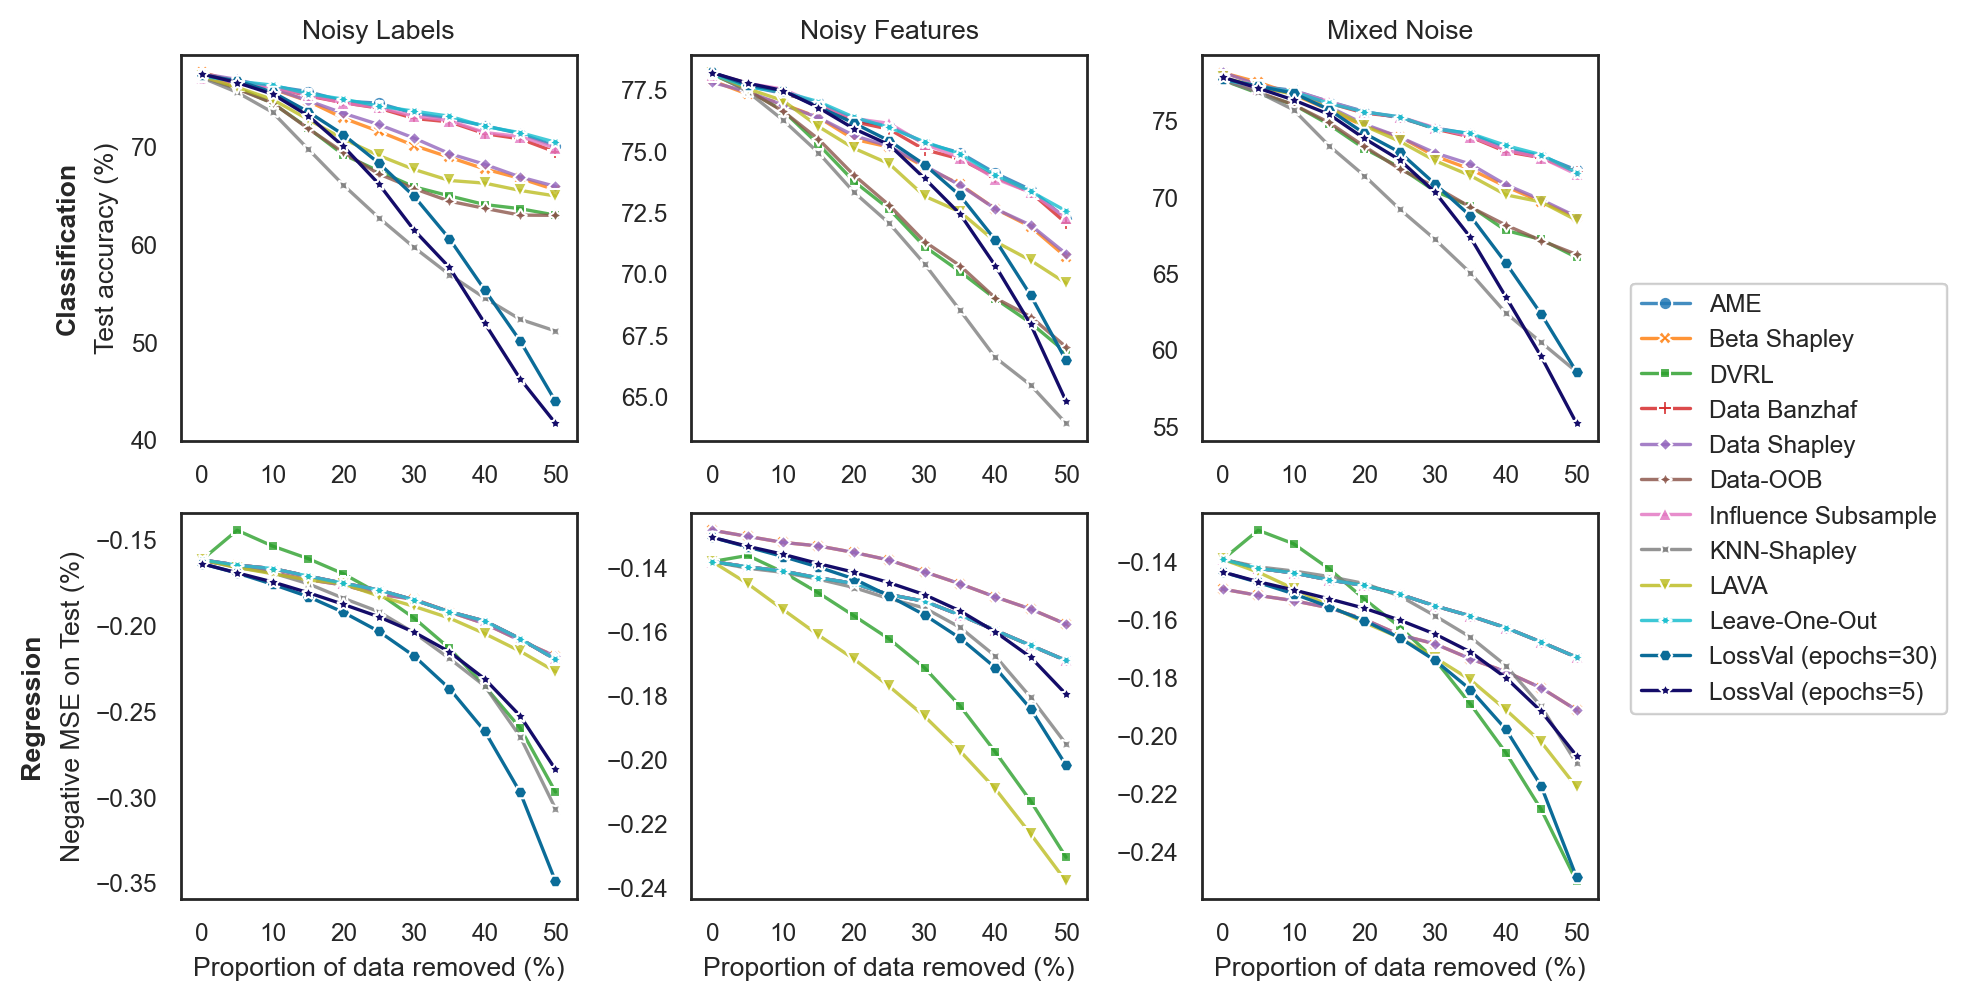

In [36]:
def plot_valuable_point_removal_both(df_class, df_regr, noise_rate=0.2, save_path=None, alpha=0.8):
    warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
    list_of_plots = ['Noisy Labels', 'Noisy Features', 'Mixed Noise']
    print("Subplots to create:", list_of_plots)

    n_cols = len(list_of_plots)
    fig, axs = plt.subplots(2, n_cols, figsize=(LATEX_TEXTWIDTH_INCHES*0.8, LATEX_TEXTWIDTH_INCHES/2), layout='constrained',)
    
    df_class = df_class.sort_values(by='method')
    df_regr = df_regr.sort_values(by='method')
    
    df_scaled_class = df_class[df_class["noise_rate"] == noise_rate].copy()
    df_scaled_class['axis'] = df_scaled_class['axis'] * 100     # Because it is in percentage
    
    df_regr_scaled = df_regr[df_regr["noise_rate"] == noise_rate].copy()
    df_regr_scaled['axis'] = df_regr_scaled['axis'] * 100       # Because it is in percentage
        
    # If either classification or regression is missing a method, remove it from both and print a warning:
    methods_used = set(df_scaled_class["method"].unique()) & set(df_regr_scaled["method"].unique())
    removed_methods = set(df_class["method"].unique()) ^ set(df_regr["method"].unique())
    if len(removed_methods) > 0:
        print("Warning: Some methods are missing from either classification or regression. Removed:", removed_methods)
        df_scaled_class = df_scaled_class[df_scaled_class["method"].isin(methods_used)]
        df_regr_scaled = df_regr_scaled[df_regr_scaled["method"].isin(methods_used)]

    class_grouped = df_scaled_class.groupby(['method', 'plot_axis', 'noise_rate', 'axis']).mean(numeric_only=True)['remove_high_valued']
    max_acc_score = min(100, class_grouped.max() + 5)
    min_acc_score = max(0, class_grouped.min() - 5)  

    regr_grouped = df_regr_scaled.groupby(['method', 'plot_axis', 'noise_rate', 'axis']).mean(numeric_only=True)['remove_high_valued']
    max_mse_score = regr_grouped.max() + abs(regr_grouped.max()*0.1)
    min_mse_score = regr_grouped.min() - abs(regr_grouped.min()*0.1)
    
    # Classification (top row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[0, i]
        
        df_plot = df_scaled_class[df_scaled_class['plot_axis'] == plot_axis]
        df_plot = df_plot[df_plot['axis'] <= 50]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='remove_high_valued', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        
        ax.set_title(plot_axis)
        # ax.set_ylim(None, max_acc_score)
        ax.set_xlim(-3, 53)
        ax.set_xticks([0, 10, 20, 30, 40, 50])

        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("Test accuracy (%)")
            ymin, ymax = ax.get_ylim()
            ax.text(-19, (ymin+ymax)/2, "Classification", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)
            
        ax.set_xlabel(None)
        ax.legend()

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1, 0.5))
        ax.get_legend().remove()  # Remove the legend from the subplot
    
    # Regression (second row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[1, i]
        
        df_plot = df_regr_scaled[df_regr_scaled['plot_axis'] == plot_axis]
        df_plot = df_plot[df_plot['axis'] <= 50]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='remove_high_valued', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        
        # ax.set_ylim(min_mse_score, max_mse_score)
        ax.set_xlim(-3, 53)
        ax.set_xticks([0, 10, 20, 30, 40, 50])

        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("Negative MSE on Test (%)")
            ymin, ymax = ax.get_ylim()
            ax.text(-24, (ymin+ymax)/2, "Regression", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)

        ax.set_xlabel("Proportion of data removed (%)")
        ax.get_legend().remove()  # Remove the legend from the subplot

    plt.tight_layout()
    
    if save_path is not None:
        print(f"Saving figure to {save_path}")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    
plot_valuable_point_removal_both(plotting_df_class, plotting_df_regr_temp, save_path=os.path.join(FIGURES_PATH, "exp_2/valuable_point_removal.pdf"), alpha=0.8)

In [37]:
res_df_class

,method,plot_axis,mean,sem
0,AME,Mixed Noise,75.076626,0.100071
1,AME,Noisy Features,75.310177,0.098125
2,AME,Noisy Labels,74.862359,0.099279
3,AME,avg.,75.083054,0.057263
4,Beta Shapley,Mixed Noise,73.912274,0.105304
5,Beta Shapley,Noisy Features,74.400086,0.098272
6,Beta Shapley,Noisy Labels,73.055798,0.107494
7,Beta Shapley,avg.,73.787725,0.060026
8,DVRL,Mixed Noise,71.735278,0.112823
9,DVRL,Noisy Features,72.369399,0.112349


In [38]:
print(create_latex_table_for_point_addition_and_removal(res_df_class))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              74.86$\pm$0.10 &              75.31$\pm$0.10 &              75.08$\pm$0.10 &              75.08$\pm$0.06 \\
Beta Shapley        &              73.06$\pm$0.11 &              74.40$\pm$0.10 &              73.91$\pm$0.11 &              73.79$\pm$0.06 \\
DVRL                &              70.41$\pm$0.12 &  \underline{72.37}$\pm$0.11 &     \textit{71.74}$\pm$0.11 &     \textit{71.50}$\pm$0.07 \\
Data Banzhaf        &              74.66$\pm$0.10 &              75.25$\pm$0.10 &              74.95$\pm$0.10 &              74.96$\pm$0.06 \\
Data Shapley        &              73.32$\pm$0.11 &              74.

In [39]:
print(create_latex_table_for_point_addition_and_removal(res_df_regr))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                  Noisy Labels &                Noisy Features &                   Mixed Noise &                          avg. \\
plot\_axis \\
method              &                               &                               &                               &                               \\
\midrule
\rowcolor{gray!3}
AME                 &              -0.143$\pm$0.001 &              -0.128$\pm$0.001 &              -0.129$\pm$0.001 &              -0.133$\pm$0.001 \\
Beta Shapley        &              -0.146$\pm$0.001 &              -0.122$\pm$0.001 &              -0.134$\pm$0.001 &              -0.134$\pm$0.001 \\
DVRL                &     \textbf{-0.173}$\pm$0.002 &     \textbf{-0.151}$\pm$0.002 &     \textbf{-0.154}$\pm$0.002 &     \textbf{-0.160}$\pm$0.001 \\
Data Banzhaf        &              -0.143$\pm$0.001 &              -0.128$\pm$0.001 &              -0.129$\pm$0.001 &              -0.133$\pm$0.001 \\
Data Shapley        

### Point Addition

Add the lowest valued datapoints and plot the change in test performance

Subplots to create: ['Noisy Labels', 'Noisy Features', 'Mixed Noise']


C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\3688501364.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saving figure to C:\Users\timwi\Documents\Uni\LossVal\figures\exp_2/bad_point_addition.pdf


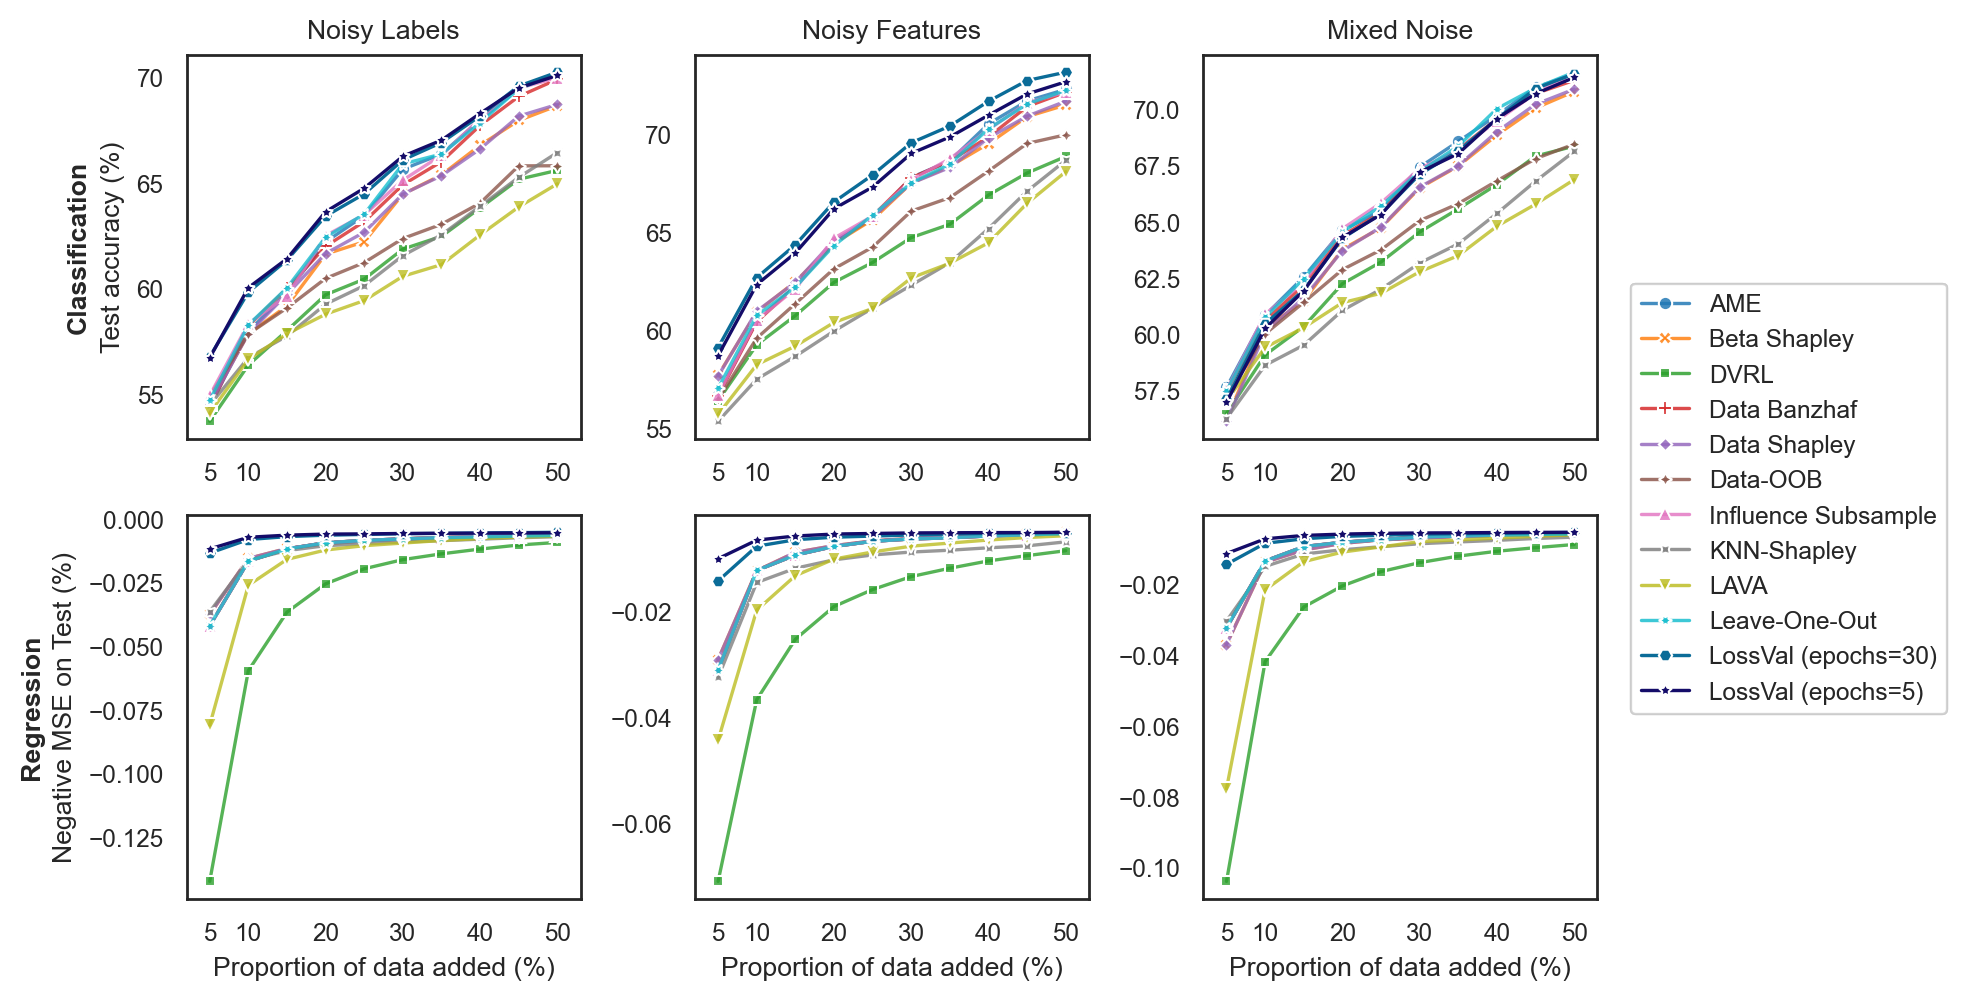

In [40]:
def plot_bad_point_addition_both(df_class, df_regr, noise_rate=0.2, save_path=None, alpha=0.8):
    warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
    list_of_plots = ['Noisy Labels', 'Noisy Features', 'Mixed Noise']
    print("Subplots to create:", list_of_plots)

    n_cols = len(list_of_plots)
    fig, axs = plt.subplots(2, n_cols, figsize=(LATEX_TEXTWIDTH_INCHES*0.8, LATEX_TEXTWIDTH_INCHES/2), layout='constrained',)
    
    df_class = df_class.sort_values(by='method')
    df_regr = df_regr.sort_values(by='method')
        
    df_scaled_class = df_class[df_class["noise_rate"] == noise_rate].copy()
    df_scaled_class['axis'] = df_scaled_class['axis'] * 100     # Because it is in percentage
    
    df_regr_scaled = df_regr[df_regr["noise_rate"] == noise_rate].copy()
    df_regr_scaled['axis'] = df_regr_scaled['axis'] * 100       # Because it is in percentage
    
    # For addition, we need to invert the x-axis (-> 1 - 'axis') because the data simulates removal:
    df_scaled_class['axis'] = 100 - df_scaled_class['axis']
    df_regr_scaled['axis'] = 100 - df_regr_scaled['axis']
        
    # If either classification or regression is missing a method, remove it from both and print a warning:
    methods_used = set(df_scaled_class["method"].unique()) & set(df_regr_scaled["method"].unique())
    removed_methods = set(df_class["method"].unique()) ^ set(df_regr["method"].unique())
    if len(removed_methods) > 0:
        print("Warning: Some methods are missing from either classification or regression. Removed:", removed_methods)
        df_scaled_class = df_scaled_class[df_scaled_class["method"].isin(methods_used)]
        df_regr_scaled = df_regr_scaled[df_regr_scaled["method"].isin(methods_used)]
    
    class_grouped = df_scaled_class.groupby(['method', 'plot_axis', 'noise_rate', 'axis']).mean(numeric_only=True)['add_low_valued']
    max_acc_score = min(100, class_grouped.max() + 5)
    min_acc_score = max(0, class_grouped.min() - 5)    

    regr_grouped = df_regr_scaled.groupby(['method', 'plot_axis', 'noise_rate', 'axis']).mean(numeric_only=True)['add_low_valued']
    max_mse_score = regr_grouped.max() + abs(regr_grouped.max()*0.1)
    min_mse_score = regr_grouped.min() - abs(regr_grouped.min()*0.1)
    
    # Classification (top row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[0, i]
        
        df_plot = df_scaled_class[df_scaled_class['plot_axis'] == plot_axis]
        df_plot = df_plot[df_plot['axis'] <= 50]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='add_low_valued', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        
        ax.set_title(plot_axis)
        # ax.set_ylim(min_acc_score, max_acc_score)
        ax.set_xlim(2, 53)
        ax.set_xticks([5, 10, 20, 30, 40, 50])

        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("Test accuracy (%)")
            ymin, ymax = ax.get_ylim()
            ax.text(-12, (ymin+ymax)/2, "Classification", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)
            
        ax.set_xlabel(None)
        ax.legend()

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1, 0.5))
        ax.get_legend().remove()  # Remove the legend from the subplot
        plt.grid(None)
    
    # Regression (second row)
    for i, plot_axis in enumerate(list_of_plots):
        ax = axs[1, i]
        
        df_plot = df_regr_scaled[df_regr_scaled['plot_axis'] == plot_axis]
        df_plot = df_plot[df_plot['axis'] <= 50]
        df_plot.sort_values(by=["method"], inplace=True)
        
        sns.lineplot(data=df_plot, x='axis', y='add_low_valued', hue='method', style="method", ax=ax, markers=True, errorbar=ERRORBAR, err_style=ERR_STYLE, dashes=False, palette=color_dict)
        # ax.set_yscale("symlog")
        
        # ax.set_ylim(min_mse_score, max_mse_score)
        ax.set_xlim(2, 53)
        # ax.set_ylim(None, 0.1)
        ax.set_xticks([5, 10, 20, 30, 40, 50])

        # Only set the labels for the outermost subplots
        if i == 0:
            ax.set_ylabel("Negative MSE on Test (%)")
            ymin, ymax = ax.get_ylim()
            ax.text(-18, (ymin+ymax)/2, "Regression", va='center', ha='center', fontweight="bold", rotation='vertical')
        else:
            ax.set_ylabel(None)

        ax.set_xlabel("Proportion of data added (%)")
        ax.get_legend().remove()  # Remove the legend from the subplot
        plt.grid(None)

    plt.tight_layout()
    
    if save_path is not None:
        print(f"Saving figure to {save_path}")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    
plot_bad_point_addition_both(plotting_df_class, plotting_df_regr_temp, save_path=os.path.join(FIGURES_PATH, "exp_2/bad_point_addition.pdf"), alpha=0.8)

In [41]:
res_df_class = calculate_avg_for_point_addition_and_removal(plotting_df_class[plotting_df_class["axis"] >= 0.5],
                                                            "add_low_valued")
res_df_regr = calculate_avg_for_point_addition_and_removal(plotting_df_regr_temp[plotting_df_regr_temp["axis"] >= 0.5],
                                                           "add_low_valued")

In [42]:
print(create_latex_table_for_point_addition_and_removal(res_df_class))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method              &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
AME                 &              64.96$\pm$0.16 &              65.88$\pm$0.16 &              65.81$\pm$0.16 &              65.55$\pm$0.09 \\
Beta Shapley        &              63.98$\pm$0.15 &              65.58$\pm$0.15 &              65.18$\pm$0.16 &              64.91$\pm$0.09 \\
DVRL                &     \textit{61.33}$\pm$0.16 &     \textit{63.38}$\pm$0.15 &     \textit{62.79}$\pm$0.16 &     \textit{62.50}$\pm$0.09 \\
Data Banzhaf        &              64.71$\pm$0.16 &              65.81$\pm$0.16 &              65.67$\pm$0.16 &              65.40$\pm$0.09 \\
Data Shapley        &              64.22$\pm$0.15 &              65.

In [43]:
print(create_latex_table_for_point_addition_and_removal(res_df_regr))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                  Noisy Labels &                Noisy Features &                   Mixed Noise &                          avg. \\
plot\_axis \\
method              &                               &                               &                               &                               \\
\midrule
\rowcolor{gray!3}
AME                 &              -0.011$\pm$0.000 &              -0.009$\pm$0.000 &              -0.010$\pm$0.000 &              -0.010$\pm$0.000 \\
Beta Shapley        &              -0.011$\pm$0.000 &              -0.009$\pm$0.000 &              -0.010$\pm$0.000 &              -0.010$\pm$0.000 \\
DVRL                &     \textbf{-0.030}$\pm$0.001 &     \textbf{-0.021}$\pm$0.001 &     \textbf{-0.025}$\pm$0.001 &     \textbf{-0.025}$\pm$0.000 \\
Data Banzhaf        &              -0.011$\pm$0.000 &              -0.009$\pm$0.000 &              -0.010$\pm$0.000 &              -0.010$\pm$0.000 \\
Data Shapley        

## Active Data Acquisition

In [44]:
# Load data:
active_data_acq = pd.read_csv(ACTIVE_DATA_ACQUISITION_PATH)
# active_data_acq = active_data_acq.drop(columns=["experiment", "repetition"])

# Repetitions indicated retraining the base model for reducing noise -> drop it
active_data_acq = active_data_acq.drop(columns=["repetition"])
active_data_acq = active_data_acq.groupby(["experiment", "state"]).mean(numeric_only=True).reset_index()
active_data_acq = active_data_acq.drop(columns=["experiment"])

active_data_acq

,state,mse,mape,r2
0,AME,0.260555,0.797163,-0.053367
1,DVRL,0.284125,0.894620,-0.148657
2,DataBanzhaf,0.270091,0.839656,-0.091919
3,DataOob,0.258219,0.788534,-0.043926
4,InfluenceSubsample,0.275969,0.827171,-0.115686
...,...,...,...,...
595,LeaveOneOut,318.974285,0.654366,-58.090377
596,LossVal (epochs = 30),373.882479,0.705656,-68.262185
597,LossVal (epochs = 5),325.776120,0.659490,-59.350425
598,Random,397.452251,0.716745,-72.628517


C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\62402142.py:5: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x=metric, hue="state", palette=color_palette)


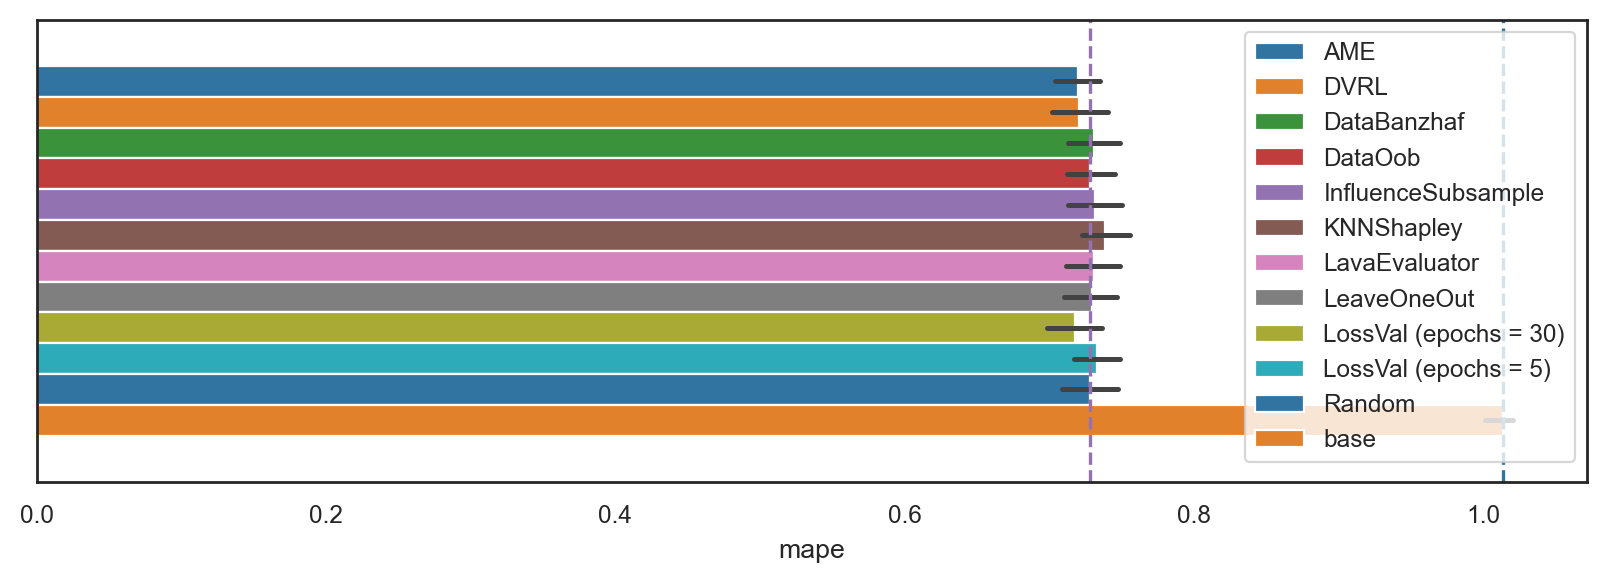

C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\62402142.py:5: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x=metric, hue="state", palette=color_palette)


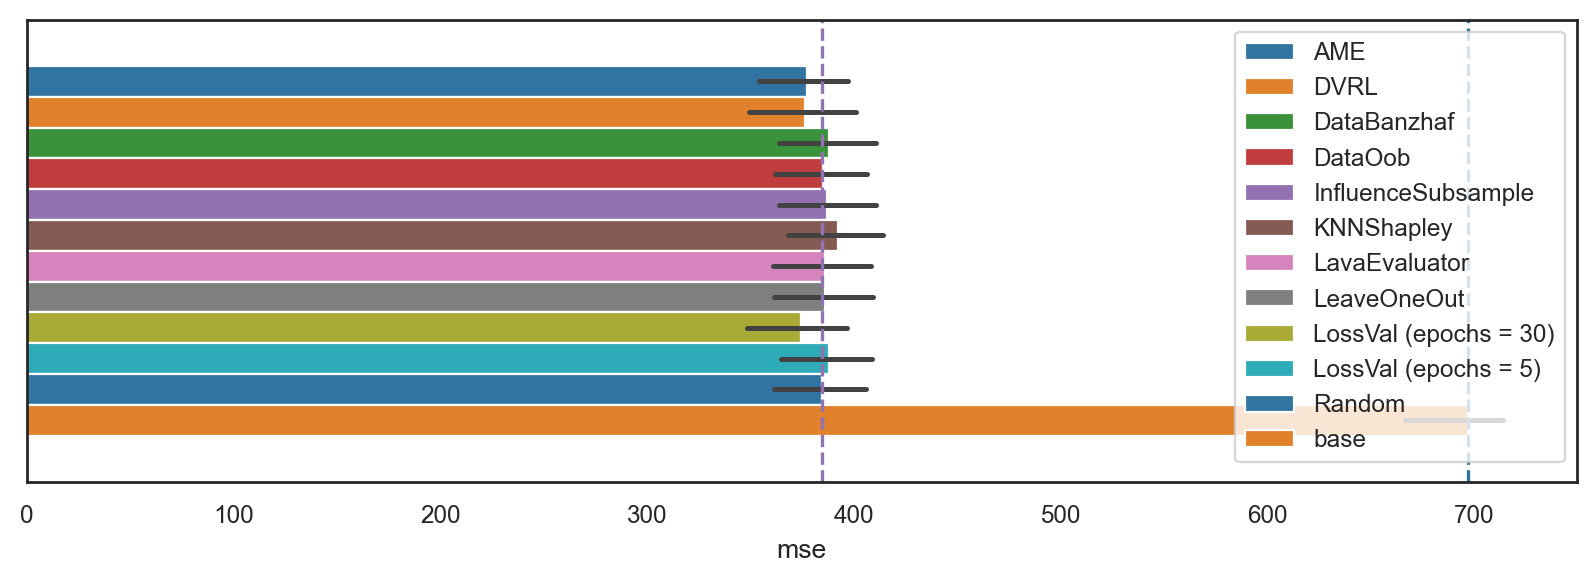

C:\Users\timwi\AppData\Local\Temp\ipykernel_36188\62402142.py:5: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x=metric, hue="state", palette=color_palette)


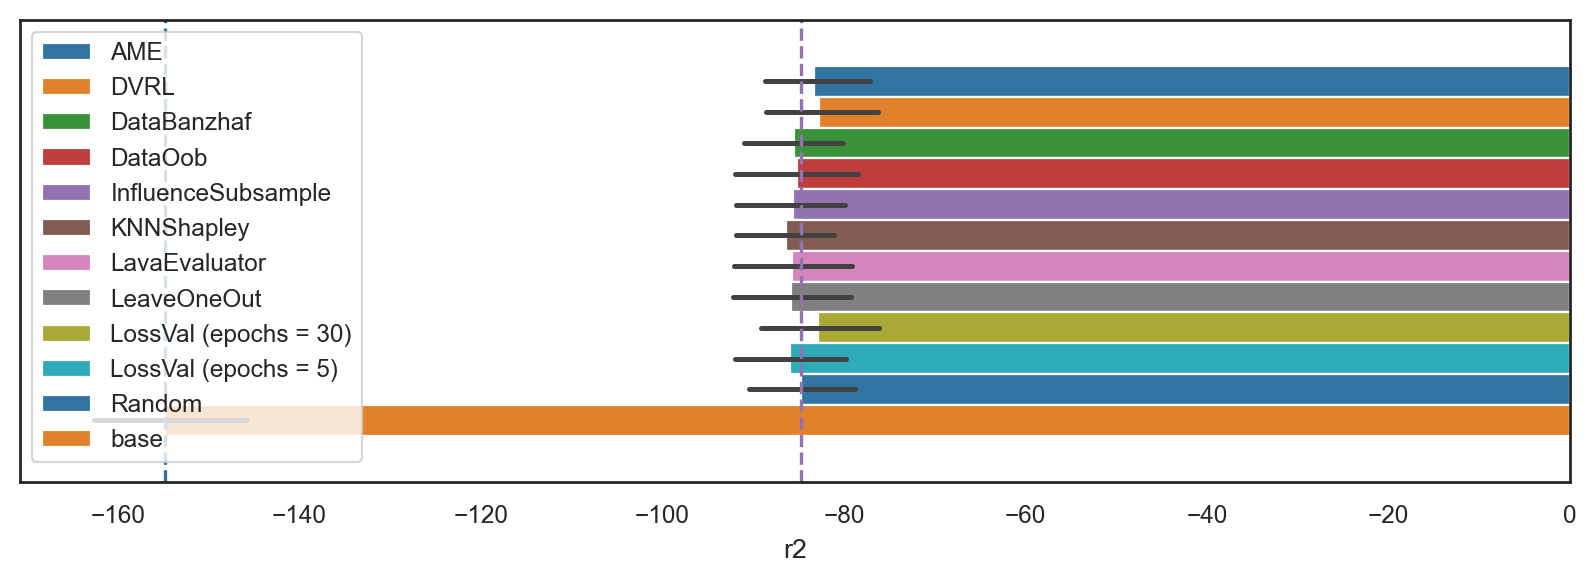

In [45]:
# Get default color palette (COLOR_PALETTE; map method names to colors)
def create_barplot(df, metric, min_x, max_x):
    # Set size to (3, 3)
    plt.figure(figsize=(10, 3))
    sns.barplot(data=df, x=metric, hue="state", palette=color_palette)
    plt.axvline(x=df[df["state"] == "base"][metric].mean(), color='#3274a1', linestyle='--')
    plt.axvline(x=df[df["state"] == "Random"][metric].mean(), color='#9372b2', linestyle='--')
    
    # plt.xlim([min_x, max_x])
        
    plt.legend()
    plt.show()

create_barplot(active_data_acq, "mape", 0, 6)
create_barplot(active_data_acq, "mse", 0.2, 0.3)
create_barplot(active_data_acq, "r2", 0.6, 0.7)

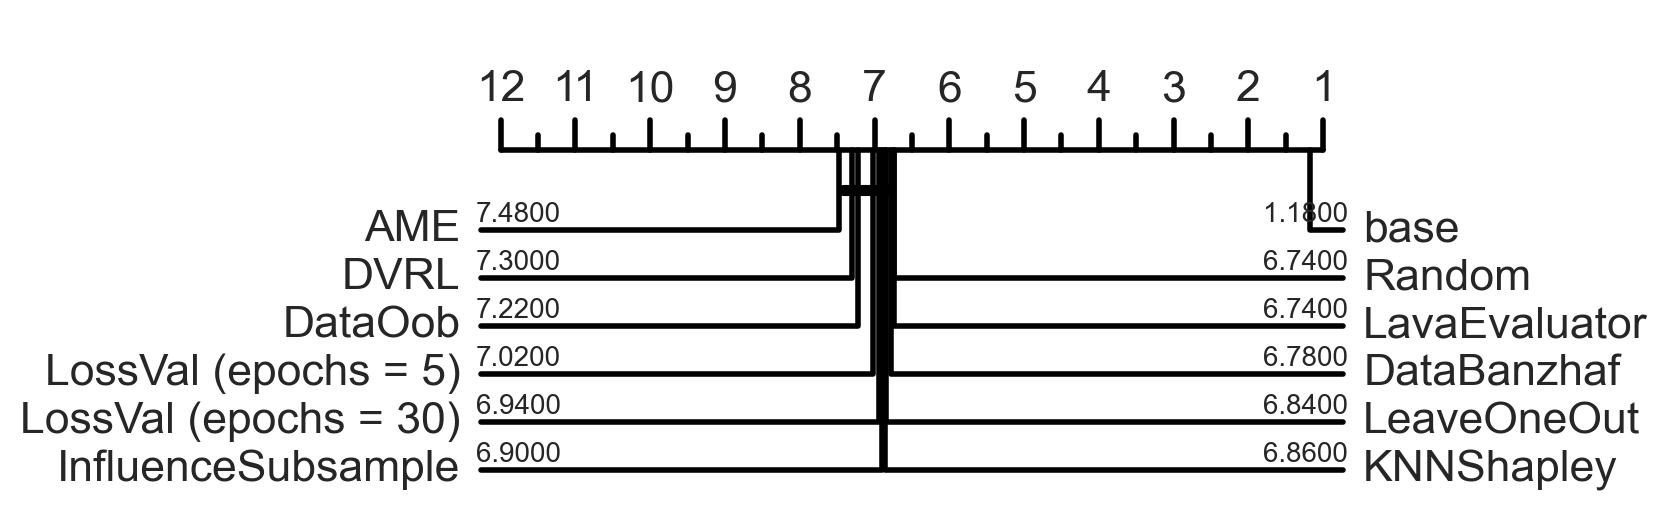

In [46]:
data_acq_for_cdd = pd.read_csv(ACTIVE_DATA_ACQUISITION_PATH)
data_acq_for_cdd = data_acq_for_cdd.rename(columns={"state": "classifier_name", "mse": "accuracy", "experiment": "dataset_name"})
# data_acq_for_cdd["dataset_name"] = data_acq_for_cdd["dataset_name"].astype(str) + "-" + data_acq_for_cdd["repetition"].astype(str)
data_acq_for_cdd = data_acq_for_cdd.groupby(["dataset_name", "classifier_name"]).mean().reset_index()
cdd.draw_cd_diagram(data_acq_for_cdd, target_path=os.path.join(FIGURES_PATH, "exp_3/active_data_acquisition_cdd.pdf"), title=None, labels=True, width=LATEX_TEXTWIDTH_INCHES*0.7)

In [47]:
data_acq = pd.read_csv(ACTIVE_DATA_ACQUISITION_PATH)
data_acq_agg = data_acq.groupby(["experiment", "state"]).mean().reset_index().drop(columns=["experiment", "repetition"]).reset_index(drop=True).groupby("state").agg(["mean", "sem"]).reset_index()
data_acq_agg

state         mse                 mape            \
                                 mean        sem      mean       sem   
0                     AME  377.558195  10.915503  0.719875  0.008028   
1                    DVRL  376.631285  12.639815  0.720930  0.010264   
2             DataBanzhaf  388.162186  12.421097  0.730835  0.009628   
3                 DataOob  385.352583  11.954563  0.728453  0.008845   
4      InfluenceSubsample  387.274412  12.042541  0.731625  0.009217   
5              KNNShapley  392.252886  11.718626  0.738348  0.008548   
6           LavaEvaluator  386.035202  12.292249  0.731242  0.009870   
7             LeaveOneOut  386.219468  12.406967  0.729427  0.009600   
8   LossVal (epochs = 30)  374.551191  12.085131  0.718126  0.009958   
9    LossVal (epochs = 5)  387.853613  11.410955  0.733438  0.008555   
10                 Random  384.612905  12.258819  0.728177  0.010241   
11                   base  697.290888  14.327389  1.013990  0.005917   

            r2            
          mean       sem  
0   -83.340754  2.860584  
1   -82.731912  3.030035  
2   -85.540545  3.043563  
3   -85.132552  3.217172  
4   -85.572418  3.164104  
5   -86.427984  2.840102  
6   -85.699350  3.418129  
7   -85.842221  3.465501  
8   -82.811042  3.196791  
9   -85.889340  3.116491  
10  -84.762524  3.048112  
11 -154.764601  4.274197

In [48]:
def create_latex_table_for_metrics(df):
    latex_cols = ["mse", "mape", "r2"]
    
    # Clean the dataframe and pivot it to match the structure we need
    # df_clean = df.iloc[2:]  # Skip the first row with 'mean' and 'sem' headers
    df_clean = df.copy()
    df_clean.columns = ["method", "mse_mean", "mse_sem", "mape_mean", "mape_sem", "r2_mean", "r2_sem"]
    
    # Convert columns to numeric where possible
    df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
    
    # Prepare LaTeX table formatting
    for col in latex_cols:
        df_clean[f"{col}_rank"] = df_clean[f"{col}_mean"].rank(ascending=False if col == "r2" else True)
        df_clean[f"{col}_rank"] = df_clean[f"{col}_rank"].apply(
            lambda x: "\\textbf{" if x == 1 else "\\underline{" if x == 2 else "\\textit{" if x == 3 else ""
        )
        df_clean[col] = df_clean[f"{col}_mean"].apply(lambda x: f"{x:.2f}")
        df_clean[col] = df_clean[f"{col}_rank"] + df_clean[col].astype(str) + df_clean[f"{col}_rank"].apply(lambda x: "}" if x != "" else "")

        df_clean[f"{col}_sem"] = df_clean[f"{col}_sem"].apply(lambda x: f"{x:.2f}")
        df_clean[col] = df_clean[col] + "$\\pm$" + df_clean[f"{col}_sem"]

    # Create the latex table
    df_latex = df_clean[["method"] + latex_cols].set_index("method")
    
    latex_table = df_latex.to_latex(escape=False)
    latex_table = latex_table.replace("\\toprule", "\\toprule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\midrule", "\\midrule\n\\rowcolor{gray!3}")
    latex_table = latex_table.replace("\\bottomrule", "\\bottomrule\n\\rowcolor{gray!6}")
    
    return latex_table

# Generate the LaTeX table
data_acq_agg = data_acq_agg.rename(columns={"state": "method"})
data_acq_agg = name_mapping(data_acq_agg)
latex_table_output = create_latex_table_for_metrics(data_acq_agg)
print(latex_table_output)

\begin{tabular}{llll}
\toprule
\rowcolor{gray!6}
{} &                           mse &                       mape &                           r2 \\
method                &                               &                            &                              \\
\midrule
\rowcolor{gray!3}
AME                   &     \textit{377.56}$\pm$10.92 &  \underline{0.72}$\pm$0.01 &     \textit{-83.34}$\pm$2.86 \\
DVRL                  &  \underline{376.63}$\pm$12.64 &     \textit{0.72}$\pm$0.01 &     \textbf{-82.73}$\pm$3.03 \\
Data Banzhaf          &              388.16$\pm$12.42 &              0.73$\pm$0.01 &              -85.54$\pm$3.04 \\
Data-OOB              &              385.35$\pm$11.95 &              0.73$\pm$0.01 &              -85.13$\pm$3.22 \\
Influence Subsample   &              387.27$\pm$12.04 &              0.73$\pm$0.01 &              -85.57$\pm$3.16 \\
KNN-Shapley           &              392.25$\pm$11.72 &              0.74$\pm$0.01 &              -86.43$\pm$2.84 \\
LAVA   

In [49]:
importance_scores_df = pd.read_csv(ACTIVE_DATA_ACQUISITION_IMPORTANCE_SCORES_PATH)
importance_scores_df["evaluator"] = importance_scores_df["evaluator"].apply(lambda x: x if "LossVal" not in x else re.sub(r"\s=\s", "=", x))
importance_scores_df["importance_scores"] = importance_scores_df["importance_scores"].apply(lambda x: np.asarray(re.sub(r"\s+", " ", x.replace("\n", "").replace("]", "").replace("[", "")).strip().split(" ")).astype(float))

importance_scores_df.rename(columns={"evaluator": "method"}, inplace=True)
importance_scores_df = name_mapping(importance_scores_df)

importance_scores_df

,method,importance_scores
0,LossVal (epochs=5),"[0.9590464, 0.91300195, 1.0954485, 1.0629054, ..."
1,LossVal (epochs=30),"[0.89038485, 0.7479226, 0.63893002, 0.79887646..."
2,Random,"[0.36655464, 0.63221001, 0.0241473, 0.63507364..."
3,Influence Subsample,"[-0.00389979149, 0.000306107477, -0.0092889406..."
4,Leave-One-Out,"[0.034582153, -0.065343678, -0.0423719585, -0...."
...,...,...
5495,Data-OOB,"[0.28883591, 0.19653937, 0.25054252, 0.1817125..."
5496,AME,"[-0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -..."
5497,DVRL,"[0.6097215, 0.6097215, 0.6097215, 0.6097215, 0..."
5498,KNN-Shapley,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


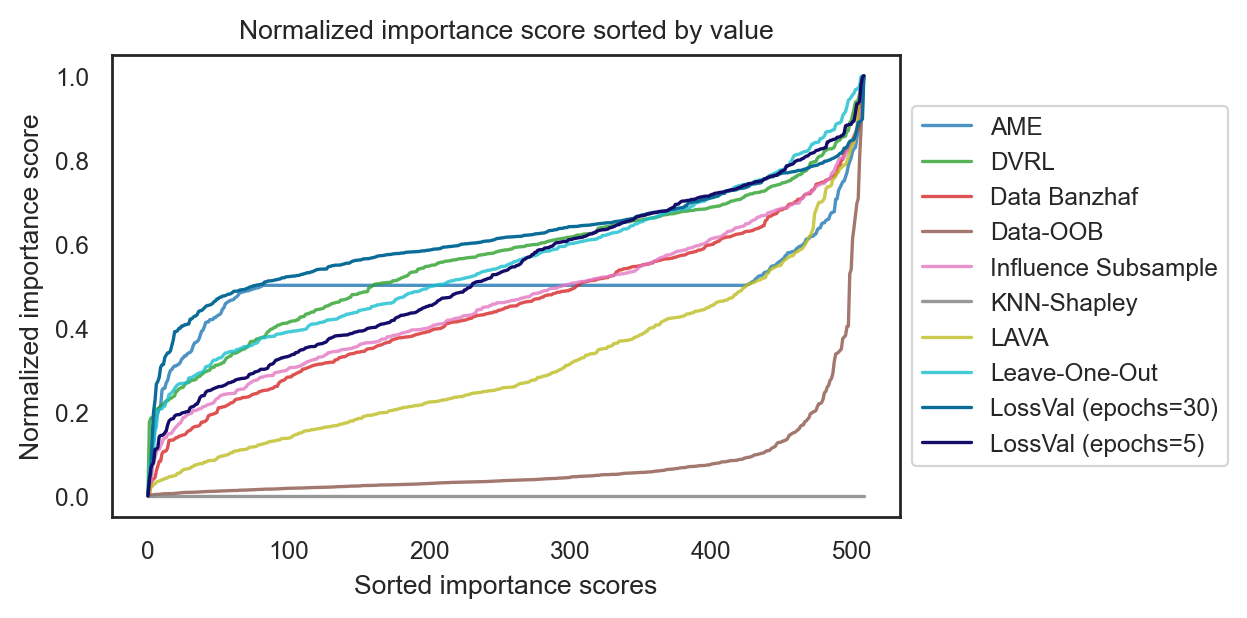

<Figure size 640x480 with 0 Axes>

In [50]:
# Average all the lists elementwise when the evaluator is the same
importance_scores_df = importance_scores_df.groupby('method').agg('mean').reset_index()
# Normalize the importance scores
importance_scores_df['importance_scores'] = importance_scores_df['importance_scores'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-10))
# Sort the values of each list:
importance_scores_df['importance_scores'] = importance_scores_df['importance_scores'].apply(lambda x: np.sort(x))

plt.figure(figsize=(LATEX_TEXTWIDTH_INCHES/2, 3))
for index, row in importance_scores_df.iterrows():
    if "Random" in row['method']:
        # plt.plot(row['importance_scores'], label=row['method'], color="red")
        pass
    else:
        plt.plot(row['importance_scores'], label=row['method'], color=color_dict[row['method']])

plt.title('Normalized importance score sorted by value')
plt.xlabel('Sorted importance scores')
plt.ylabel('Normalized importance score')
plt.legend()

# Move the legend outside the plot (to the right)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Save the plot
plt.savefig(os.path.join(FIGURES_PATH, 'importance_scores_sorted_plt.pdf'), bbox_inches='tight')

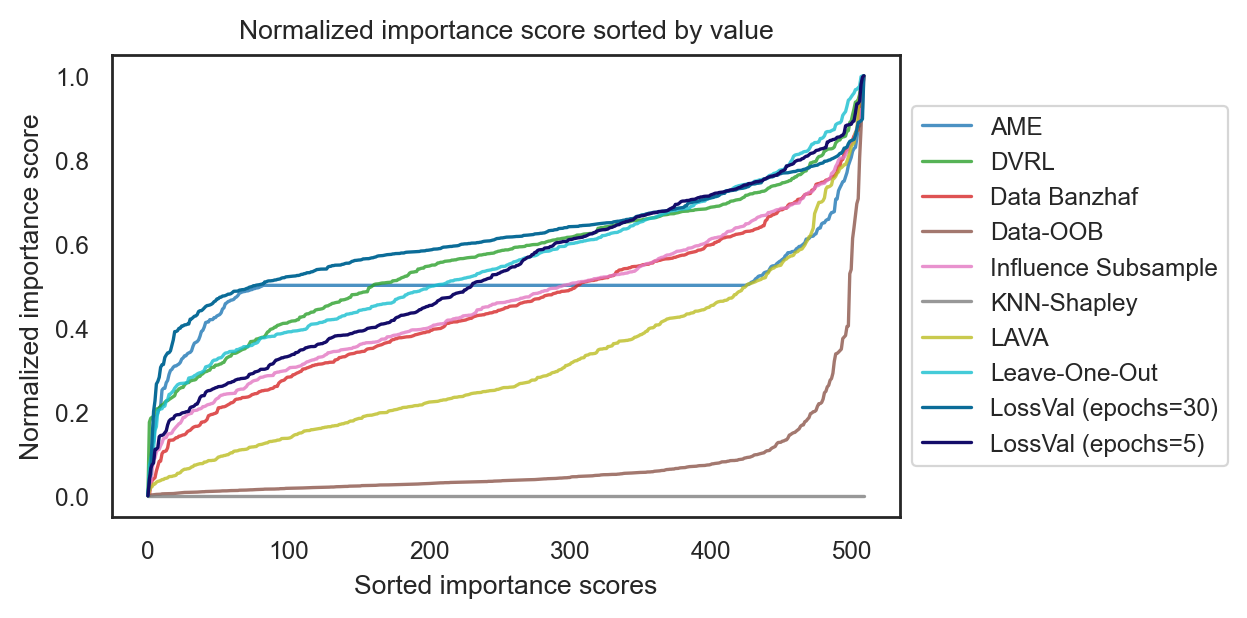

In [51]:
# Take only the first of each method:
# importance_scores_df = importance_scores_df.drop_duplicates(subset='evaluator')
iteration_nr = 0
# iteration_nr = 24
nr_evaluators = len(importance_scores_df['method'].unique())
importance_scores_df = importance_scores_df.iloc[iteration_nr * nr_evaluators: (iteration_nr + 1) * nr_evaluators]

importance_scores_df['importance_scores'] = importance_scores_df['importance_scores'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-10))

# Sort the values of each list:
importance_scores_df['importance_scores'] = importance_scores_df['importance_scores'].apply(lambda x: np.sort(x))

# Sort the data frame by evaluator
importance_scores_df = importance_scores_df.sort_values(by='method')

plt.figure(figsize=(LATEX_TEXTWIDTH_INCHES/2, 3))
for index, (_, row) in enumerate(importance_scores_df.iterrows()):
    if "Random" in row['method']:
        # plt.plot(row['importance_scores'], label=row['evaluator'], color="red")
        pass
    else:
        plt.plot(row['importance_scores'], label=row['method'], color=color_dict[row['method']])

plt.title('Normalized importance score sorted by value')
plt.xlabel('Sorted importance scores')
plt.ylabel('Normalized importance score')
plt.legend()

# Move the legend outside the plot (to the right)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the plot
plt.savefig(os.path.join(FIGURES_PATH, 'importance_scores_sorted_plt.pdf'), bbox_inches='tight')
plt.show()

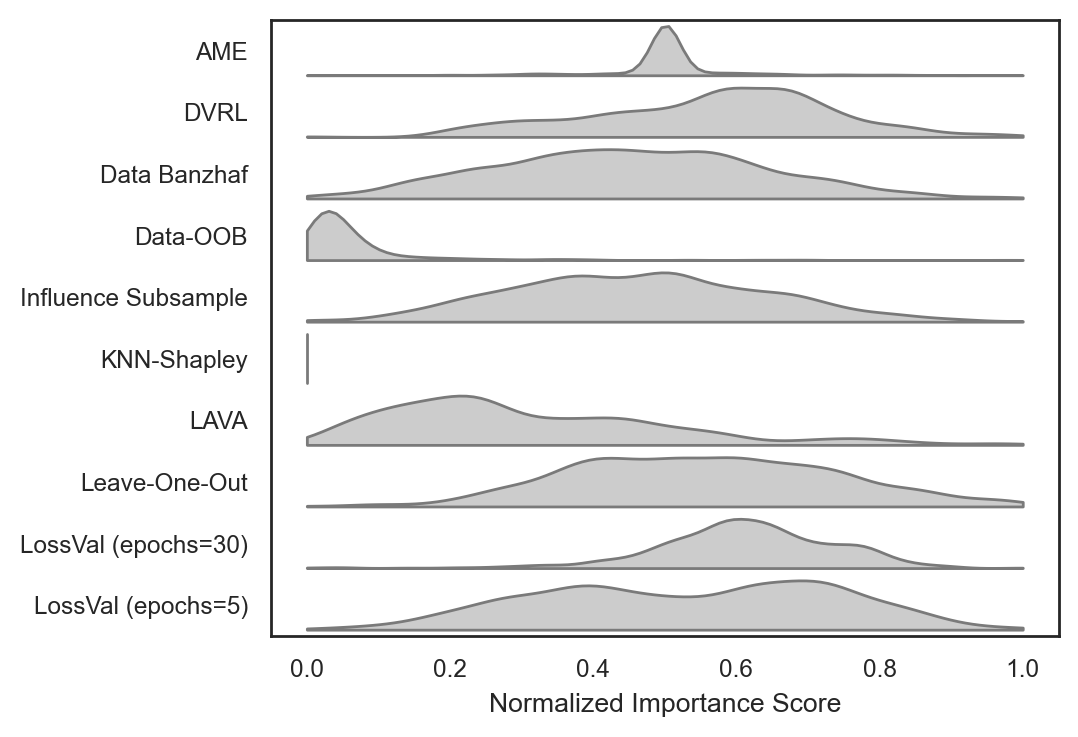

In [52]:
plt.figure(figsize=(LATEX_TEXTWIDTH_INCHES/2, 4))

importance_scores_df = importance_scores_df[~importance_scores_df["method"].str.contains("Random")]
importance_scores_df = importance_scores_df.explode('importance_scores')

# violin plot (rotated) with color
ax = sns.violinplot(data=importance_scores_df, y='method', x='importance_scores', color=".8", density_norm='count', bw_method=.2, hue_order=[True, False], split=True, inner=None, cut=0)

plt.xlabel('Normalized Importance Score')
plt.ylabel("")
# Save the plot
plt.savefig(os.path.join(FIGURES_PATH, 'importance_scores_density_plot.pdf'), bbox_inches='tight')
plt.show()


## Effect on Model Performance

In [53]:
# Load data: 
classification_results = pd.read_csv(os.path.join(ROOT_PATH, "effect_of_weighting/classification.csv"))
regression_results = pd.read_csv(os.path.join(ROOT_PATH, "effect_of_weighting/regression.csv"))

noisy_classification_results = pd.read_csv(os.path.join(ROOT_PATH, "effect_of_weighting/noisy_classification.csv"))
noisy_regression_results = pd.read_csv(os.path.join(ROOT_PATH, "effect_of_weighting/noisy_regression.csv"))

### Normal Data

#### Classification

In [54]:
degrees_of_freedom = len(classification_results[classification_results["mode"] == "normal"]) + len(classification_results[classification_results["mode"] == "weighted"]) - 2

In [55]:
classification_results

,Dataset,Cross-Entropy,Accuracy,mode
0,2dplanes,0.825262,0.488000,normal
1,2dplanes,0.801262,0.512000,weighted
2,2dplanes,0.811928,0.501333,normal
3,2dplanes,0.811928,0.501333,weighted
4,2dplanes,0.815928,0.497333,normal
...,...,...,...,...
175,nomao,0.603595,0.709667,weighted
176,nomao,0.601595,0.711667,normal
177,nomao,0.601595,0.711667,weighted
178,nomao,0.605595,0.707667,normal


In [56]:
# t-test between normal and weighted loss:
from scipy.stats import ttest_ind   
normal_loss = classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values
weighted_loss = classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values

tp = ttest_ind(normal_loss, weighted_loss)
print("Weighted loss is better!" if tp.statistic < 0 else "Normal loss is better!")
if tp.pvalue <= 0.1:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

Normal loss is better!
p > 0.1  ->  the distributions are similar. p = 0.9918960593846563
TtestResult(statistic=0.010171234791850559, pvalue=0.9918960593846563, df=178.0)


In [57]:
weighted_loss

array([0.80126178, 0.81192845, 0.8105951 , 0.81992847, 0.80859512,
       0.80392843, 0.81626177, 0.8105951 , 0.8182618 , 0.81559515,
       0.80626178, 0.81192845, 0.8232618 , 0.82392848, 0.8145951 ,
       0.8005951 , 0.82092845, 0.80692846, 0.5728479 , 0.82459515,
       0.82092845, 0.81492847, 0.81126177, 0.80259514, 0.80859512,
       0.81559515, 0.8232618 , 0.81226182, 0.8092618 , 0.82126176,
       0.82126176, 0.5776937 , 0.8195951 , 0.82492846, 0.81592846,
       0.82426178, 0.81526178, 0.8092618 , 0.81592846, 0.80092847,
       0.81292844, 0.82459515, 0.8042618 , 0.80759513, 0.82259512,
       0.63726181, 0.6472618 , 0.64126182, 0.63959515, 0.6435951 ,
       0.64326179, 0.64459515, 0.66026181, 0.65059513, 0.64792848,
       0.64759511, 0.64259511, 0.65926182, 0.6562618 , 0.64959514,
       0.81626177, 0.8105951 , 0.80959511, 0.81626177, 0.79592848,
       0.80159515, 0.8195951 , 0.81192845, 0.82459515, 0.81326181,
       0.81126177, 0.82059515, 0.83192843, 0.8182618 , 0.82092

#### Regression

In [58]:
tp = ttest_ind(regression_results[regression_results["mode"] == "normal"]["MSE"].values,
               regression_results[regression_results["mode"] == "weighted"]["MSE"].values)

print("Weighted loss is better!" if tp.statistic < 0 else "Normal loss is better!")
if tp.pvalue <= 0.05:
    print("The difference is significant!", tp)
    
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

Weighted loss is better!
p > 0.1  ->  the distributions are similar. p = 0.1768053706343978
TtestResult(statistic=-1.3560362441328464, pvalue=0.1768053706343978, df=178.0)


In [59]:
# Create basic latex table with the results: One row for classification, one row for regression. Columns: Task, Normal loss +- std, Weighted loss +- std, p-value. Then create LaTeX table (tabularx format, right aligned, \textwidth, two decimal places)
# Classification
normal_loss = classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values
weighted_loss = classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values

tp_classification = ttest_ind(normal_loss, weighted_loss).pvalue
tp_regression = ttest_ind(regression_results[regression_results["mode"] == "normal"]["MSE"].values,
                          regression_results[regression_results["mode"] == "weighted"]["MSE"].values).pvalue

print(f"               & Loss (normal) & Loss after training with LossVal & p-value \\\\")
print(f"Classification & {normal_loss.mean():.2f} $\pm$ {normal_loss.std():.2f} & {weighted_loss.mean():.2f} $\pm$ {weighted_loss.std():.2f} & {tp_classification:.2f} \\\\")
print(f"Regression     & {regression_results[regression_results['mode'] == 'normal']['MSE'].mean():.2f} $\pm$ {regression_results[regression_results['mode'] == 'normal']['MSE'].sem():.2f} & {regression_results[regression_results['mode'] == 'weighted']['MSE'].mean():.2f} $\pm$ {regression_results[regression_results['mode'] == 'weighted']['MSE'].sem():.2f} & {tp_regression:.2f} \\\\")

               & Loss (normal) & Loss after training with LossVal & p-value \\
Classification & 0.75 $\pm$ 0.09 & 0.75 $\pm$ 0.10 & 0.99 \\
Regression     & 0.31 $\pm$ 0.03 & 0.38 $\pm$ 0.03 & 0.18 \\


In [60]:
# Create basic latex table with the results: One row for classification, one row for regression. Columns: Task, Normal loss +- std, Weighted loss +- std, p-value. Then create LaTeX table (tabularx format, right aligned, \textwidth, two decimal places)
# Classification
normal_loss = classification_results[classification_results["mode"] == "normal"]["Accuracy"].values
weighted_loss = classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values

tp_classification = ttest_ind(normal_loss, weighted_loss).pvalue
tp_regression = ttest_ind(regression_results[regression_results["mode"] == "normal"]["R2"].values,
                          regression_results[regression_results["mode"] == "weighted"]["R2"].values).pvalue

print(f"               & normal & after training with LossVal & p-value \\\\")
print(f"Classification & {normal_loss.mean():.2f} $\pm$ {normal_loss.std():.2f} & {weighted_loss.mean():.2f} $\pm$ {weighted_loss.std():.2f} & {tp_classification:.2f} \\\\")
print(f"Regression     & {regression_results[regression_results['mode'] == 'normal']['R2'].mean():.2f} $\pm$ {regression_results[regression_results['mode'] == 'normal']['R2'].sem():.2f} & {regression_results[regression_results['mode'] == 'weighted']['R2'].mean():.2f} $\pm$ {regression_results[regression_results['mode'] == 'weighted']['R2'].sem():.2f} & {tp_regression:.2f} \\\\")

               & normal & after training with LossVal & p-value \\
Classification & 0.56 $\pm$ 0.09 & 0.56 $\pm$ 0.10 & 1.00 \\
Regression     & 0.68 $\pm$ 0.03 & 0.62 $\pm$ 0.03 & 0.18 \\


### Noisy Data

#### Classification

In [61]:
tp = ttest_ind(noisy_classification_results[noisy_classification_results["mode"] == "normal"]["Cross-Entropy"].values,
               noisy_classification_results[noisy_classification_results["mode"] == "weighted"]["Cross-Entropy"].values)

print("Weighted loss is better!" if tp.statistic < 0 else "Normal loss is better!")
if tp.pvalue <= 0.05:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)

Normal loss is better!
p > 0.1  ->  the distributions are similar. p = nan


#### Regression

In [62]:
tp = ttest_ind(noisy_regression_results[noisy_regression_results["mode"] == "normal"]["MSE"].values,
               noisy_regression_results[noisy_regression_results["mode"] == "weighted"]["MSE"].values)

if tp.pvalue <= 0.05:
    print("The difference is significant!", tp)
    print("Weighted loss is better!" if tp.statistic < 0 else "Normal loss is better!")
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)

p > 0.1  ->  the distributions are similar. p = 0.9827502772803918


## Ablation Study

In [63]:
def create_latex_table_for_f1(df):
    latex_cols = ["Noisy Labels", "Noisy Features", "Mixed Noise", "avg."]

    # Create a latex table for the AUC values
    df = df.pivot(index="method", columns="plot_axis", values=["mean", "sem"])

    # Highlight the best 3 results (higher is better) in each column (1st -> bold, 2nd -> underlined, 3rd -> italic)
    for col in latex_cols:
        df[f"{col}_rank"] = df["mean"][col].rank(ascending=False)
        df[f"{col}_rank"] = df[f"{col}_rank"].apply(
            lambda x: "\\textbf{" if x == 1 else "\\underline{" if x == 2 else "\\textit{" if x == 3 else "")
        df[col] = df["mean"][col].apply(lambda x: f"{x:.3f}")
        df[col] = df[f"{col}_rank"] + df[col].astype(str) + df[f"{col}_rank"].apply(lambda x: "}" if x != "" else "")

        df[f"{col}_sem"] = df["sem"][col].apply(lambda x: f"{x:.3f}"[1:])
        df[col] = df[col] + "$\\pm$" + df[f"{col}_sem"]

    # # Drop the rank columns
    df = df[latex_cols]

    # return df       
    # Convert to latex table, where the best 3 results are highlighted
    with pd.option_context("max_colwidth", 1000):
        latex_table = df.to_latex()
    latex_table = latex_table.replace("\\toprule", "\\toprule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\midrule", "\\midrule\n\\rowcolor{gray!3}")
    latex_table = latex_table.replace("\\bottomrule", "\\bottomrule\n\\rowcolor{gray!6}")
    latex_table = latex_table.replace("\\textbackslash ", "\\")
    latex_table = latex_table.replace("\\{", "{")
    latex_table = latex_table.replace("\\}", "}")
    latex_table = latex_table.replace("\\$", "$")

    return latex_table

In [64]:
temp_nl_class = LossVal_classification_results_with_ablation["noisy_feature"]["f1"]
temp_nl_class["plot_axis"] = "Noisy Features"

temp_nf_class = LossVal_classification_results_with_ablation["noisy_label"]["f1"]
temp_nf_class["plot_axis"] = "Noisy Labels"

temp_mn_class = LossVal_classification_results_with_ablation["mixed_noise"]["f1"]
temp_mn_class["plot_axis"] = "Mixed Noise"

temp_nl_regr = LossVal_regression_results_with_ablation["noisy_feature"]["f1"]
temp_nl_regr["plot_axis"] = "Noisy Features"

temp_nf_regr = LossVal_regression_results_with_ablation["noisy_label"]["f1"]
temp_nf_regr["plot_axis"] = "Noisy Labels"

temp_mn_regr = LossVal_regression_results_with_ablation["mixed_noise"]["f1"]
temp_mn_regr["plot_axis"] = "Mixed Noise"

plotting_df_class = pd.concat([temp_nl_class, temp_nf_class, temp_mn_class])
plotting_df_class = plotting_df_class[
         plotting_df_class["method"].str.contains(f"lr={BEST_LR_CLASSIFICATION}")
]

plotting_df_class = plotting_df_class[
    plotting_df_class["method"].str.contains(f"epochs=30")
] 
    
plotting_df_regr = pd.concat([temp_nl_regr, temp_nf_regr, temp_mn_regr])
plotting_df_regr = plotting_df_regr[
         plotting_df_regr["method"].str.contains(f"lr={BEST_LR_REGRESSION}")
]


plotting_df_regr = plotting_df_regr[
    (plotting_df_regr["method"].str.contains(f"epochs=30"))
]

# Remove the info in braces (lr and epochs):
plotting_df_class["method"] = plotting_df_class["method"].apply(lambda x: re.sub(r"\(lr.*\)", "", x))
plotting_df_regr["method"] = plotting_df_regr["method"].apply(lambda x: re.sub(r"\(lr.*\)", "", x))

# Remove "[ABLATION]" substring:
plotting_df_class["method"] = plotting_df_class["method"].apply(lambda x: re.sub(r"\[ABLATION\] ", "", x) if "ABLATION" in x else x)
plotting_df_regr["method"] = plotting_df_regr["method"].apply(lambda x: re.sub(r"\[ABLATION\] ", "", x))

In [65]:
class_avg = calculate_avg_for_f1(plotting_df_class)
regr_avg = calculate_avg_for_f1(plotting_df_regr)

In [66]:
print(create_latex_table_for_f1(class_avg))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method                                        &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
LossVal                                       &  \underline{0.544}$\pm$.008 &     \textit{0.204}$\pm$.004 &     \textbf{0.371}$\pm$.005 &     \textbf{0.373}$\pm$.005 \\
Sinkhorn                                      &              0.146$\pm$.003 &  \underline{0.214}$\pm$.004 &              0.196$\pm$.003 &              0.185$\pm$.002 \\
Squared Sinkhorn                              &              0.133$\pm$.003 &              0.160$\pm$.003 &              0.157$\pm$.003 &              0.150$\pm$.002 \\
Weighted CE                                   &     \textbf{0.546}$\pm$.007 &              0.153$\pm$.004 &

In [67]:
print(create_latex_table_for_f1(regr_avg))

\begin{tabular}{lllll}
\toprule
\rowcolor{gray!6}
{} &                Noisy Labels &              Noisy Features &                 Mixed Noise &                        avg. \\
plot\_axis \\
method                                         &                             &                             &                             &                             \\
\midrule
\rowcolor{gray!3}
LossVal                                        &     \textbf{0.464}$\pm$.008 &     \textbf{0.256}$\pm$.006 &     \textbf{0.354}$\pm$.006 &     \textbf{0.358}$\pm$.004 \\
Sinkhorn                                       &              0.137$\pm$.003 &  \underline{0.253}$\pm$.005 &     \textit{0.217}$\pm$.004 &              0.202$\pm$.002 \\
Squared Sinkhorn                               &              0.117$\pm$.003 &              0.137$\pm$.003 &              0.134$\pm$.003 &              0.129$\pm$.002 \\
Weighted MSE                                   &     \textit{0.230}$\pm$.005 &              0.124$\pm$.